In [42]:
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [43]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [44]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [45]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [46]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2

In [47]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        plt.plot(x, y)
        plt.show()

[1] loss: 247230.156


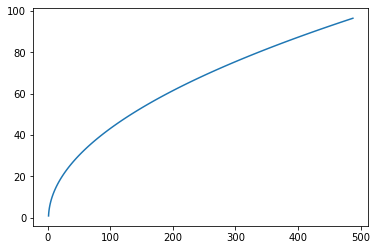

[2] loss: 247063.109


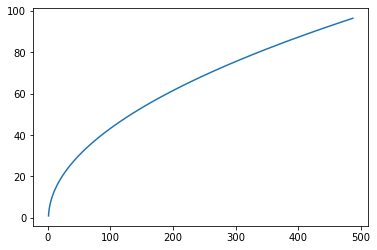

[3] loss: 246917.266


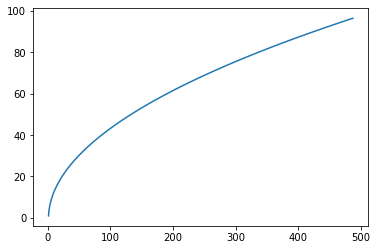

[4] loss: 246872.875


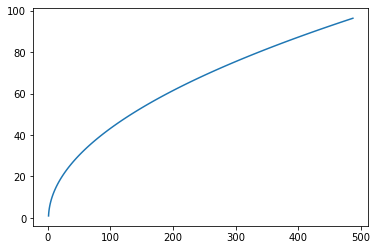

[5] loss: 246841.641


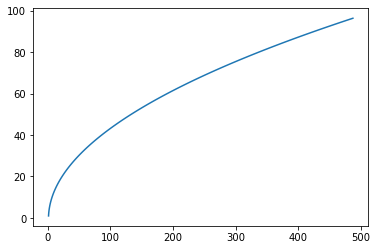

[6] loss: 246815.719


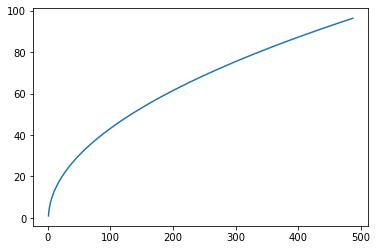

[7] loss: 246793.062


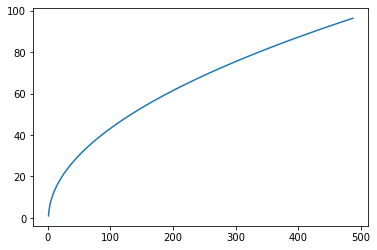

[8] loss: 246779.547


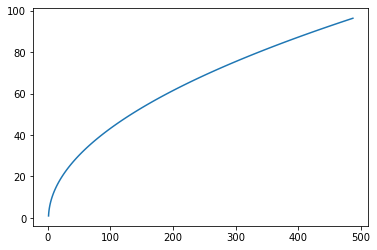

[9] loss: 246763.844


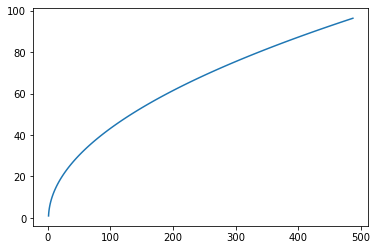

[10] loss: 246760.625


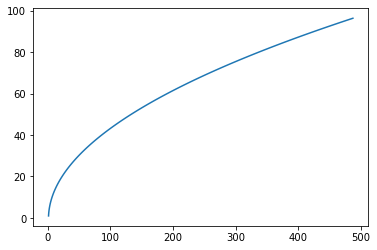

[11] loss: 246757.266


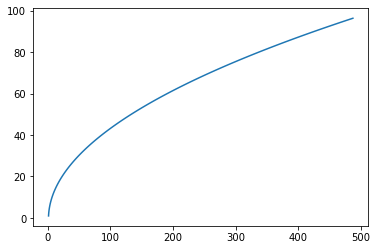

[12] loss: 246753.281


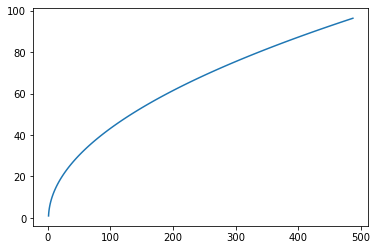

[13] loss: 246752.922


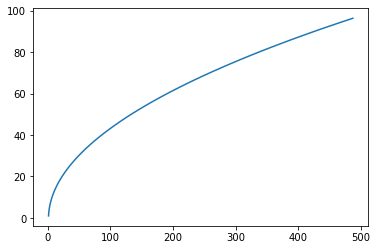

[14] loss: 246752.922


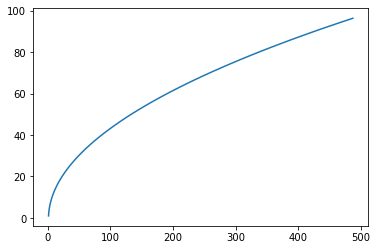

[15] loss: 246752.781


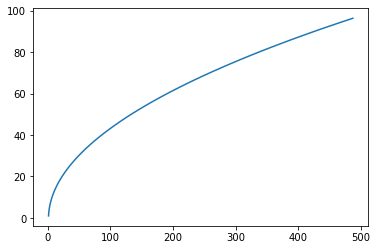

[16] loss: 246752.734


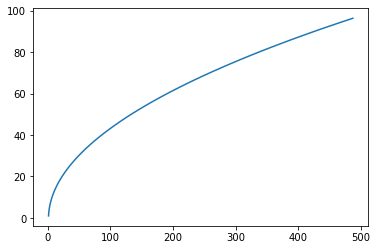

[17] loss: 246751.547


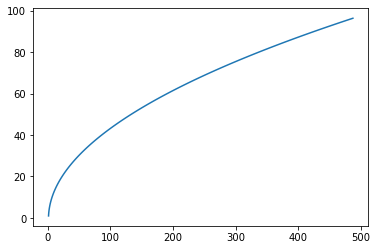

[18] loss: 246751.516


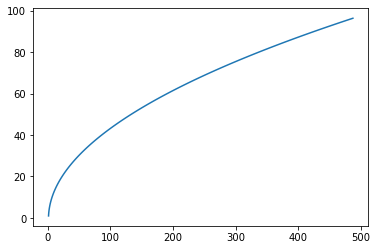

[19] loss: 246751.469


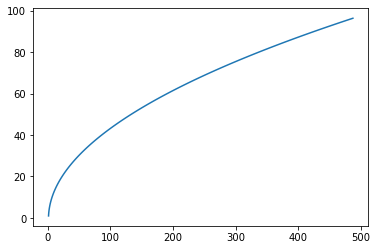

[20] loss: 246751.469


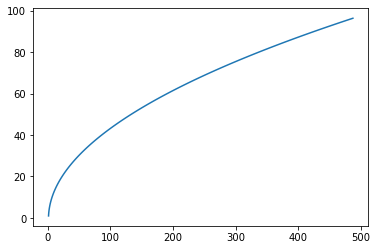

[21] loss: 246751.469


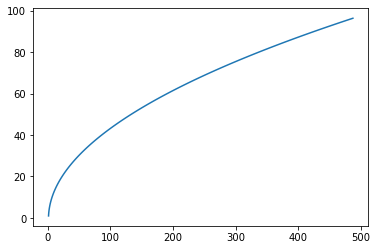

[22] loss: 246751.469


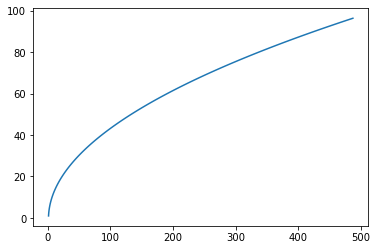

[23] loss: 246751.469


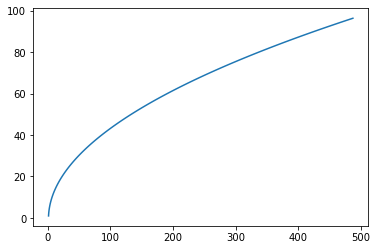

[24] loss: 246751.469


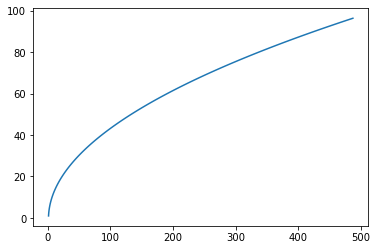

[25] loss: 246751.328


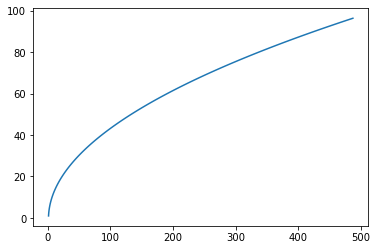

[26] loss: 246751.328


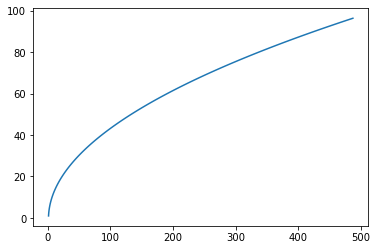

[27] loss: 246751.328


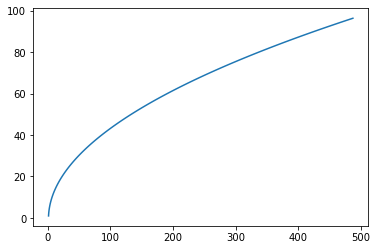

[28] loss: 246751.266


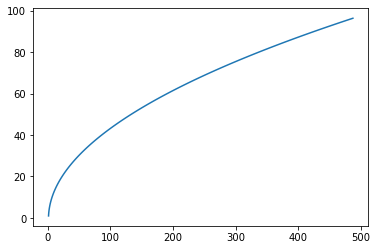

[29] loss: 246751.234


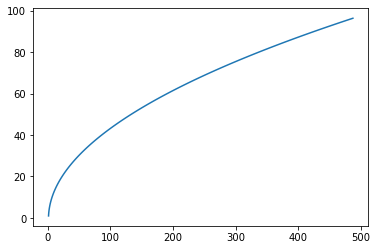

[30] loss: 246751.203


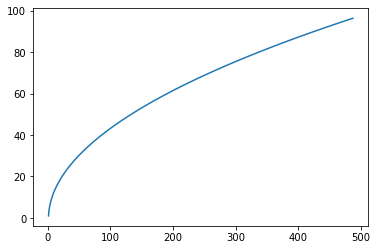

[31] loss: 246751.156


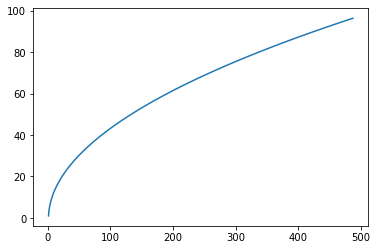

[32] loss: 246751.156


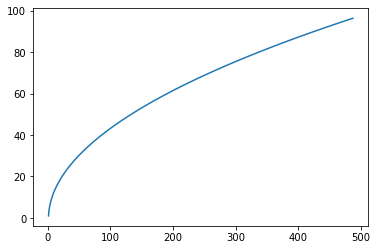

[33] loss: 246751.156


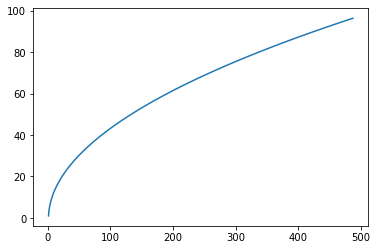

[34] loss: 246751.094


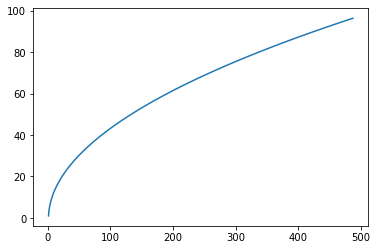

[35] loss: 246751.094


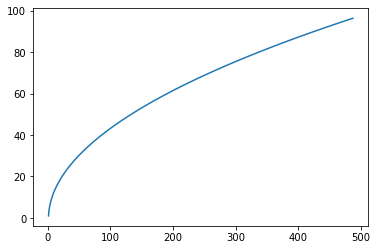

[36] loss: 246751.000


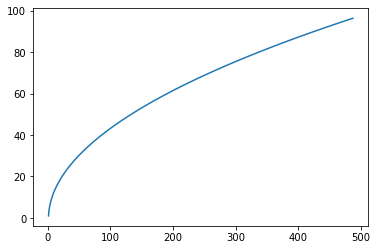

[37] loss: 246750.938


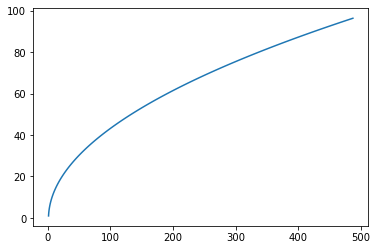

[38] loss: 246750.844


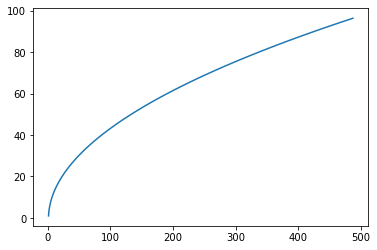

[39] loss: 246750.844


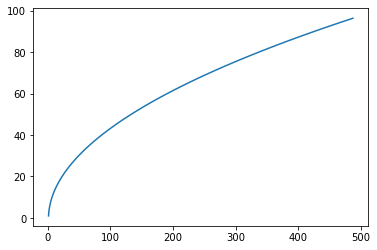

[40] loss: 246750.844


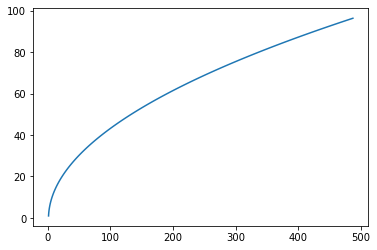

[41] loss: 246750.844


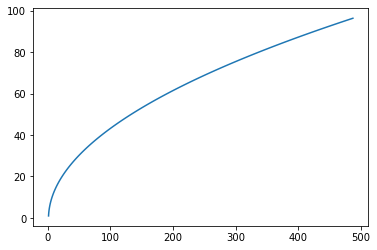

[42] loss: 246750.797


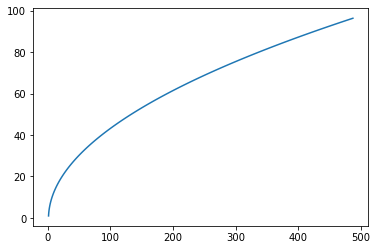

[43] loss: 246750.797


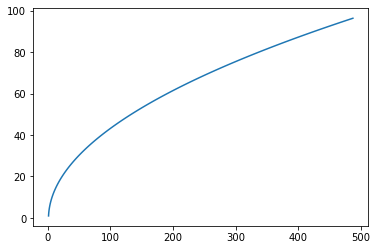

[44] loss: 246750.797


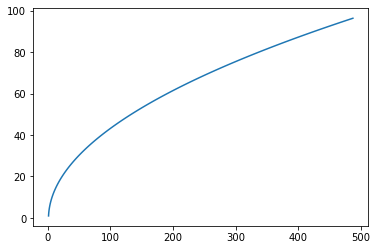

[45] loss: 246750.797


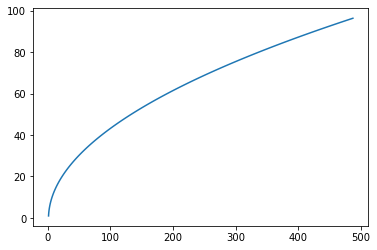

[46] loss: 246750.797


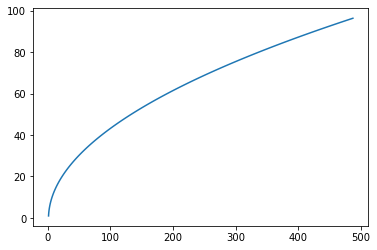

[47] loss: 246750.766


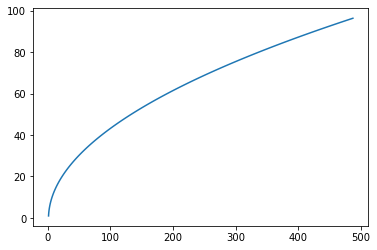

[48] loss: 246750.766


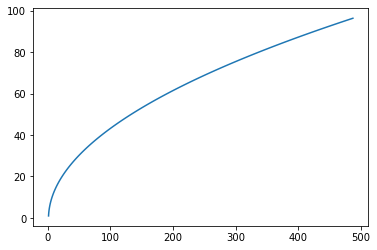

[49] loss: 246750.766


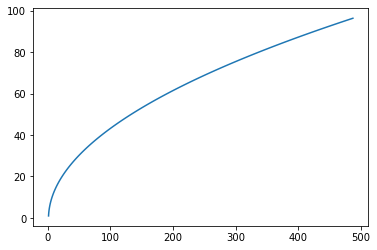

[50] loss: 246750.766


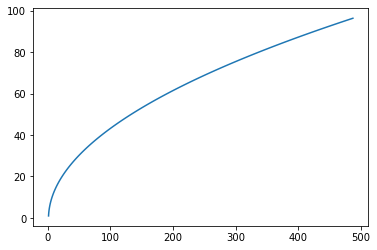

[51] loss: 246750.688


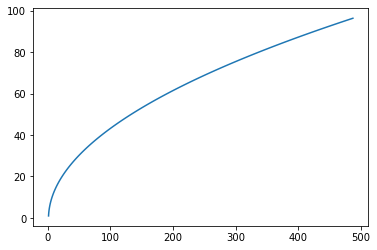

[52] loss: 246750.688


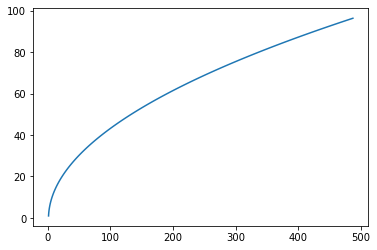

[53] loss: 246750.688


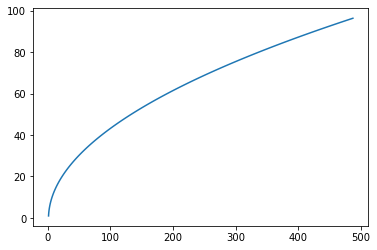

[54] loss: 246750.688


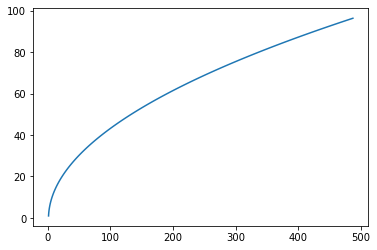

[55] loss: 246750.688


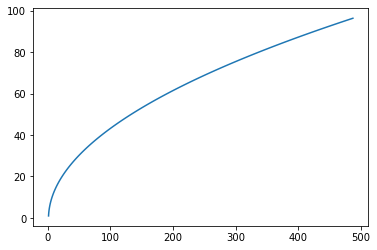

[56] loss: 246750.688


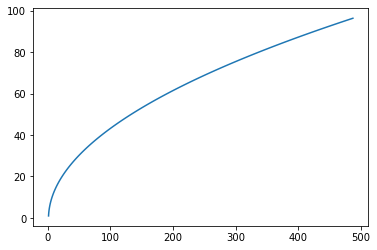

[57] loss: 246750.625


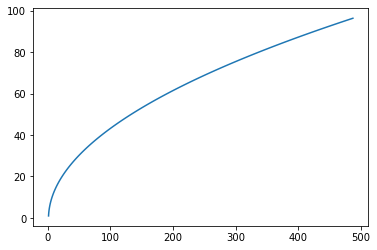

[58] loss: 246750.625


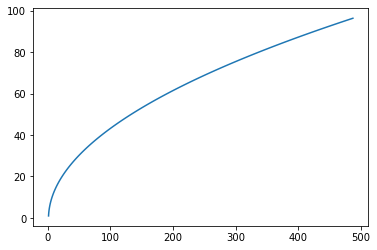

[59] loss: 246750.625


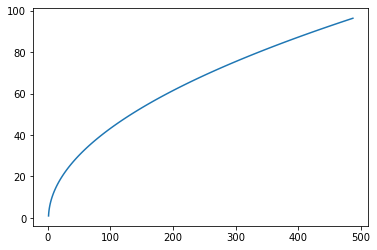

[60] loss: 246750.625


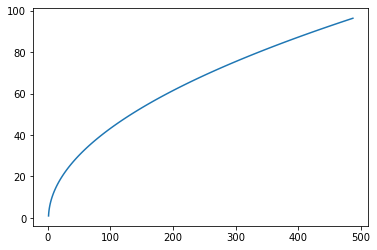

[61] loss: 246750.625


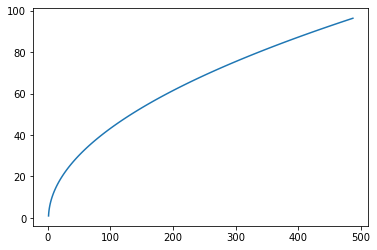

[62] loss: 246750.625


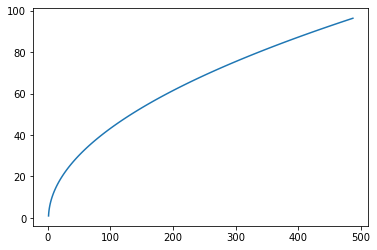

[63] loss: 246750.531


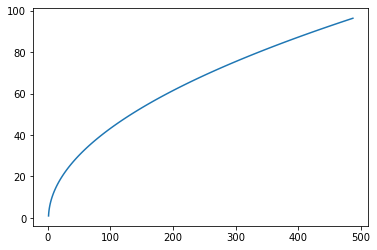

[64] loss: 246750.516


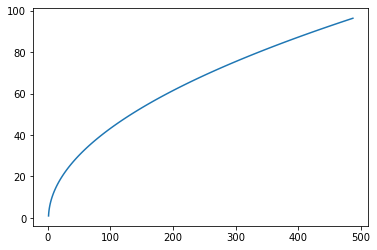

[65] loss: 246750.484


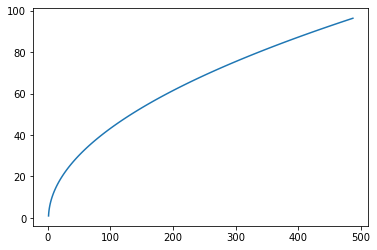

[66] loss: 246750.391


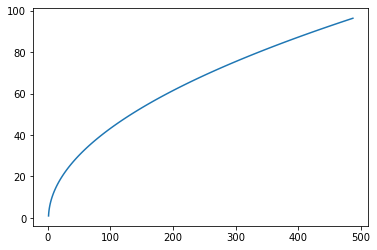

[67] loss: 246749.812


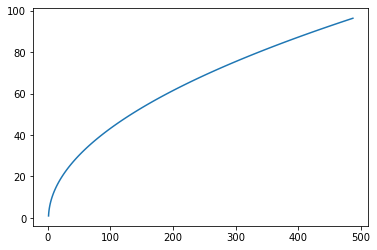

[68] loss: 246749.812


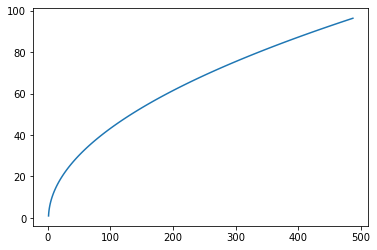

[69] loss: 246749.812


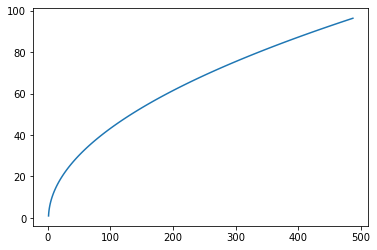

[70] loss: 246749.812


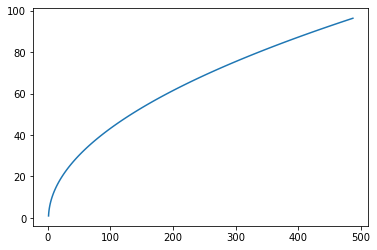

[71] loss: 246749.812


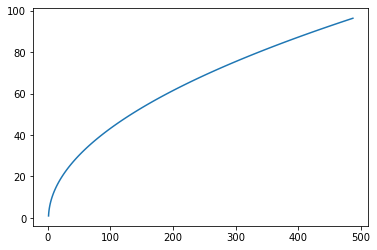

[72] loss: 246749.812


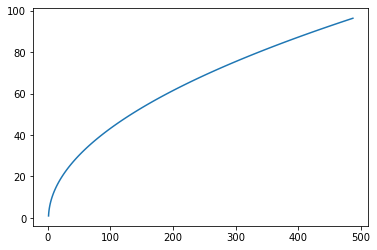

[73] loss: 246749.812


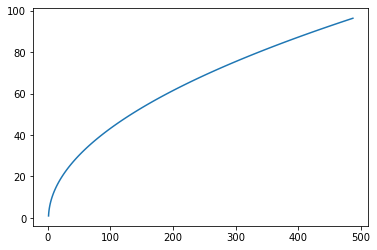

[74] loss: 246749.812


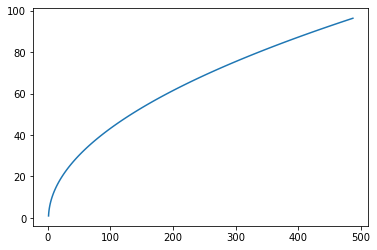

[75] loss: 246749.812


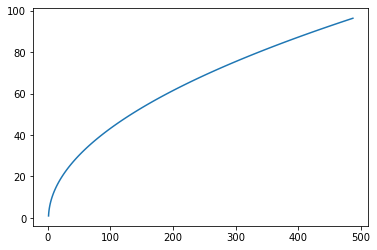

[76] loss: 246749.812


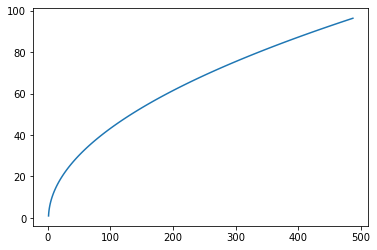

[77] loss: 246749.812


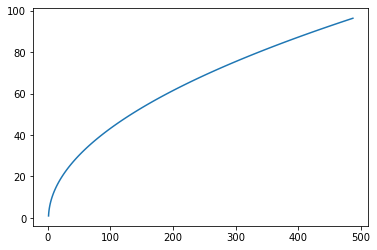

[78] loss: 246749.812


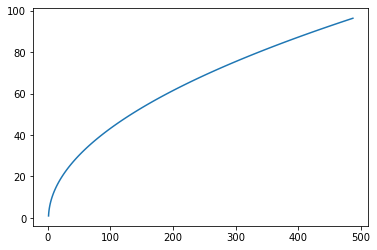

[79] loss: 246749.812


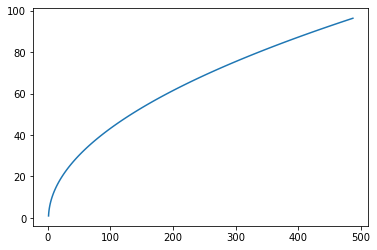

[80] loss: 246749.812


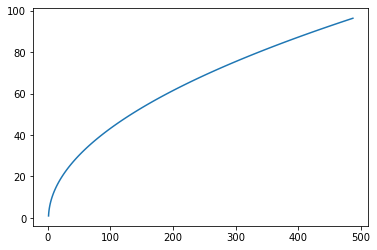

[81] loss: 246749.812


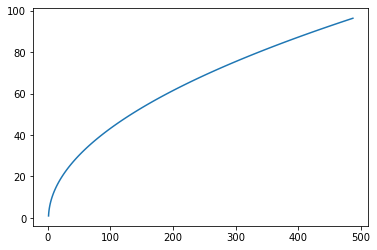

[82] loss: 246749.812


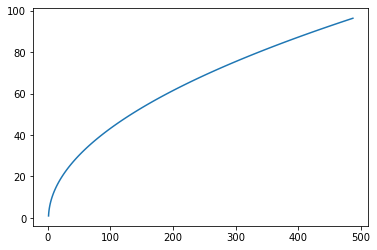

[83] loss: 246749.750


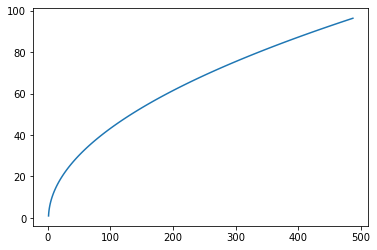

[84] loss: 246749.750


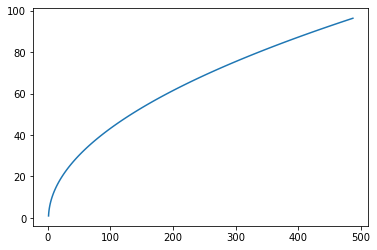

[85] loss: 246749.750


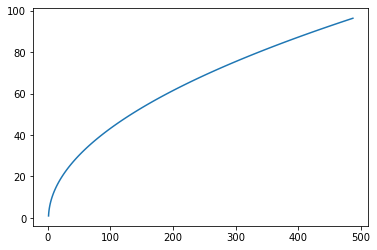

[86] loss: 246749.750


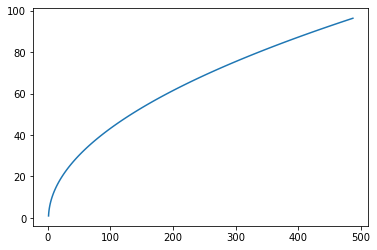

[87] loss: 246749.750


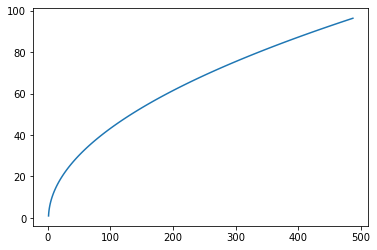

[88] loss: 246749.750


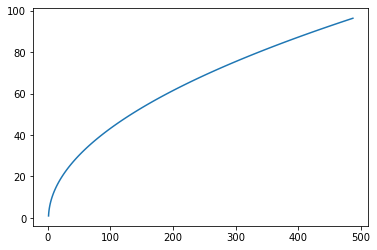

[89] loss: 246749.750


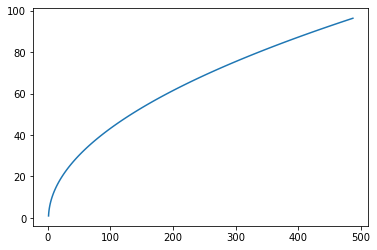

[90] loss: 246749.750


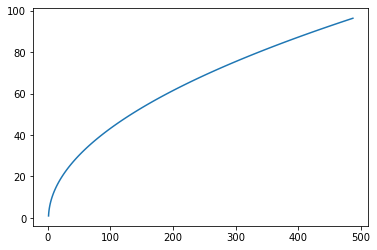

[91] loss: 246749.750


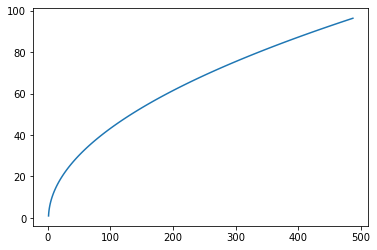

[92] loss: 246749.750


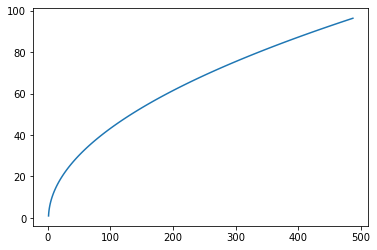

[93] loss: 246749.750


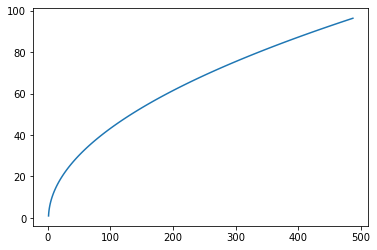

[94] loss: 246749.750


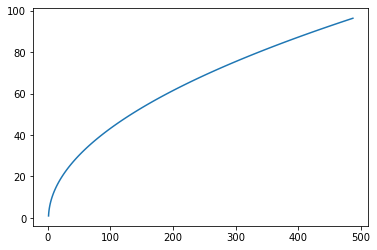

[95] loss: 246749.750


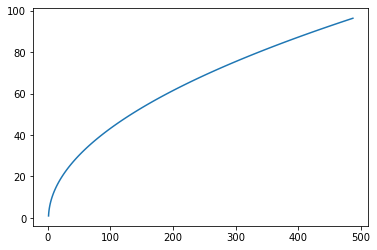

[96] loss: 246749.750


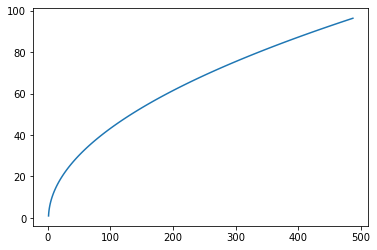

[97] loss: 246749.750


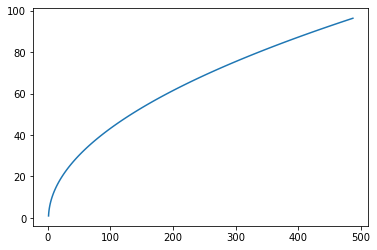

[98] loss: 246749.750


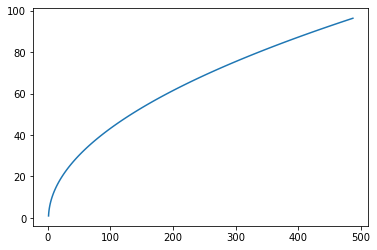

[99] loss: 246749.750


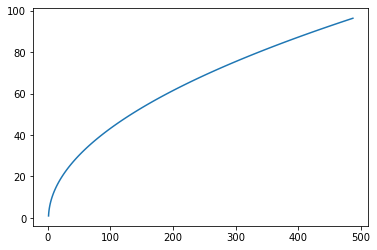

[100] loss: 246749.750


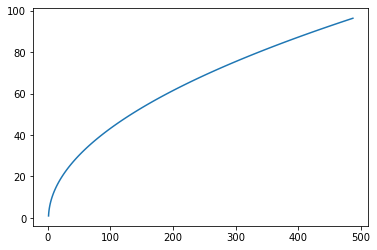

[101] loss: 246749.750


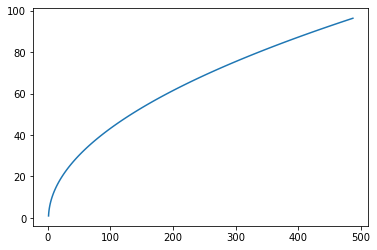

[102] loss: 246749.750


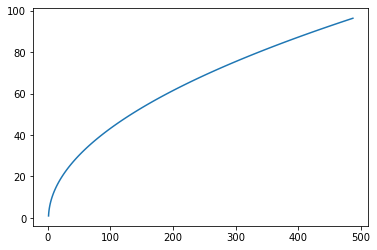

[103] loss: 246749.750


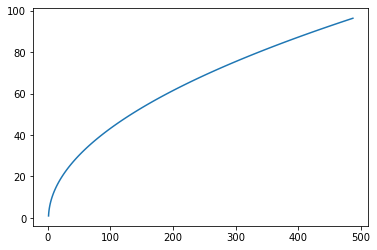

[104] loss: 246749.750


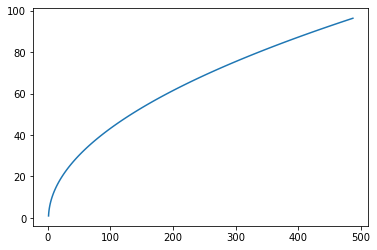

[105] loss: 246749.750


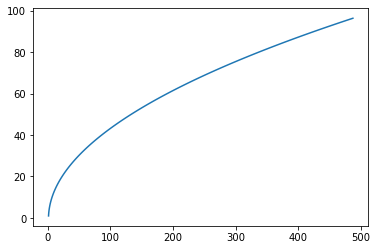

[106] loss: 246749.750


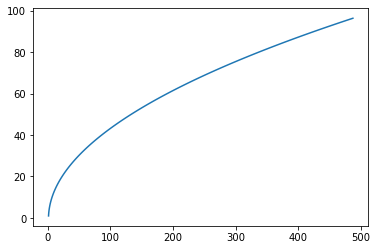

[107] loss: 246749.750


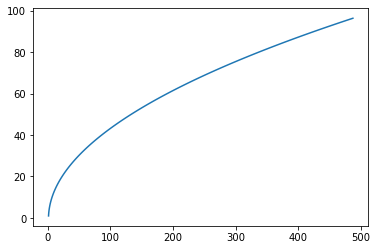

[108] loss: 246749.750


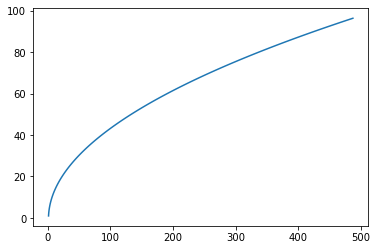

[109] loss: 246749.750


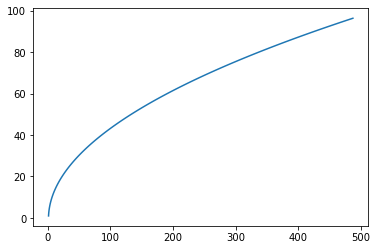

[110] loss: 246749.750


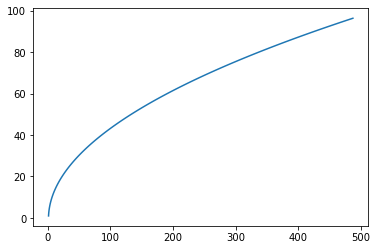

[111] loss: 246749.750


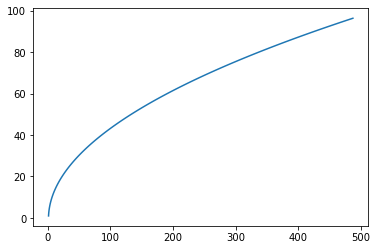

[112] loss: 246749.750


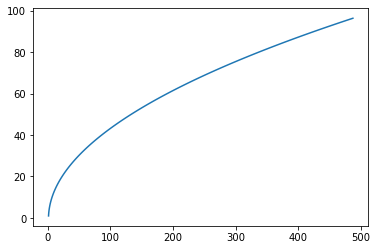

[113] loss: 246749.750


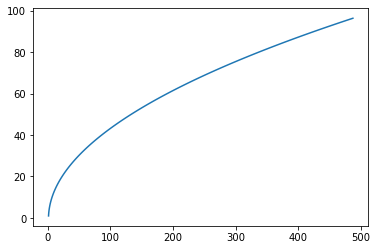

[114] loss: 246749.750


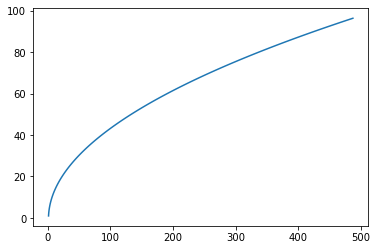

[115] loss: 246749.750


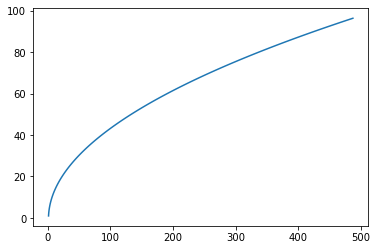

[116] loss: 246749.750


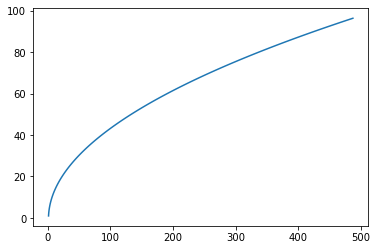

[117] loss: 246749.750


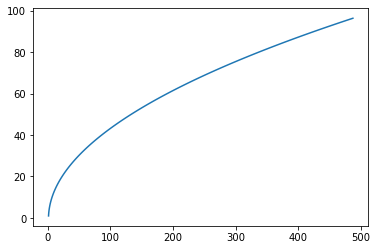

[118] loss: 246749.750


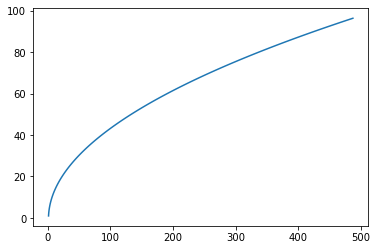

[119] loss: 246749.750


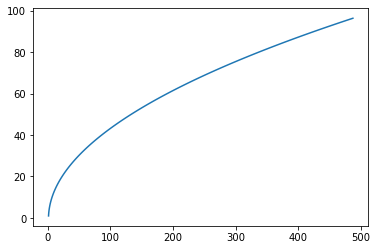

[120] loss: 246749.750


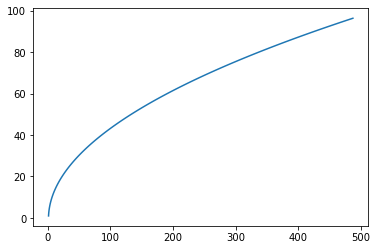

[121] loss: 246749.750


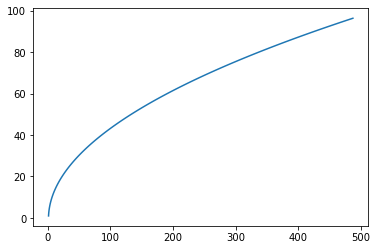

[122] loss: 246749.750


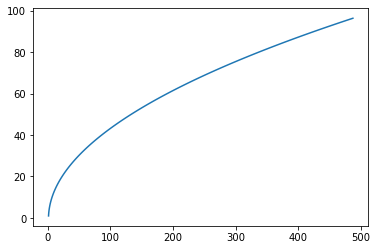

[123] loss: 246749.750


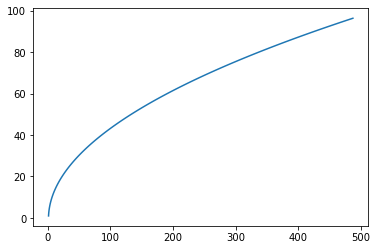

[124] loss: 246749.750


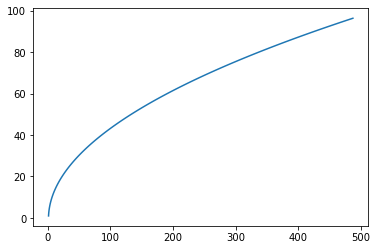

[125] loss: 246749.750


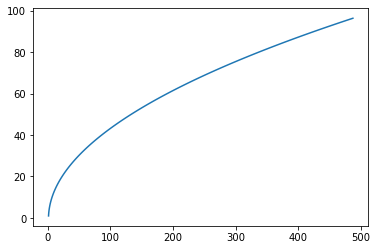

[126] loss: 246749.750


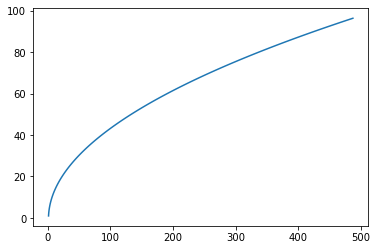

[127] loss: 246749.750


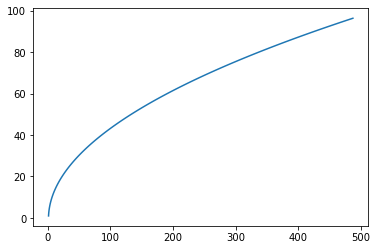

[128] loss: 246749.688


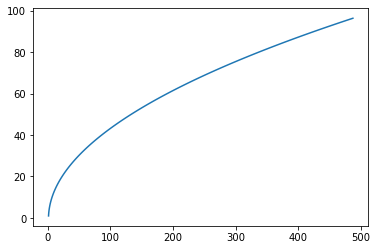

[129] loss: 246749.688


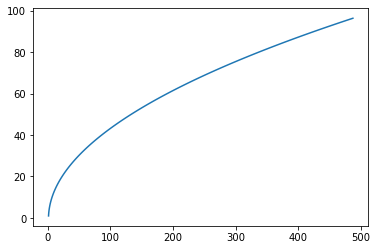

[130] loss: 246749.688


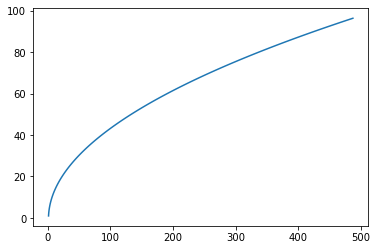

[131] loss: 246749.688


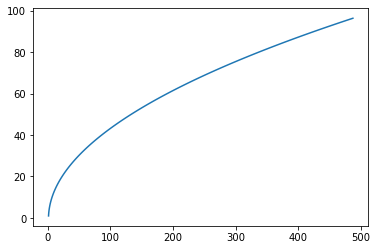

[132] loss: 246749.688


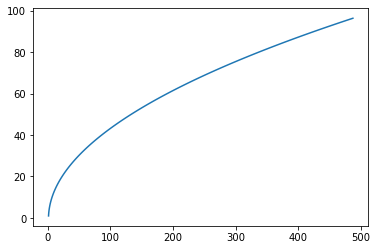

[133] loss: 246749.688


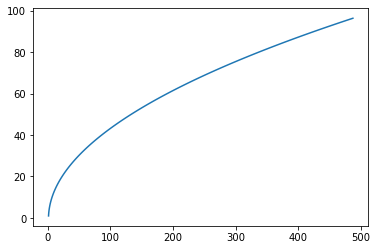

[134] loss: 246749.688


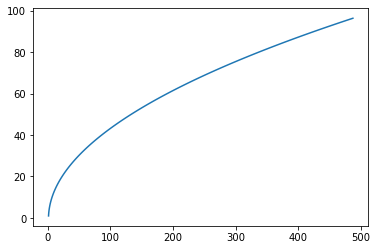

[135] loss: 246749.688


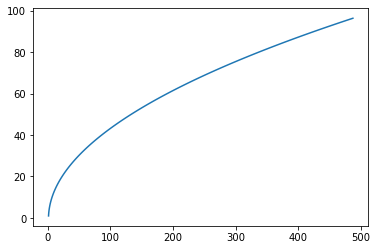

[136] loss: 246749.688


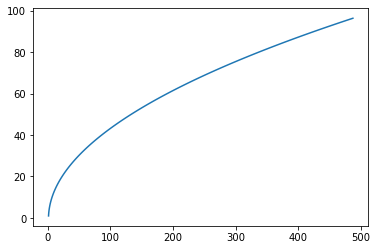

[137] loss: 246749.688


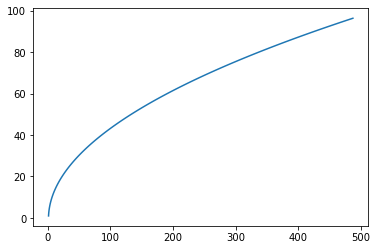

[138] loss: 246749.688


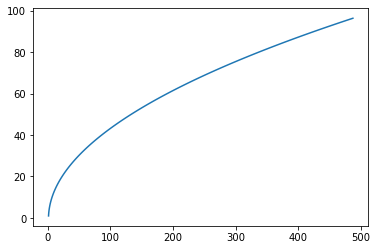

[139] loss: 246749.688


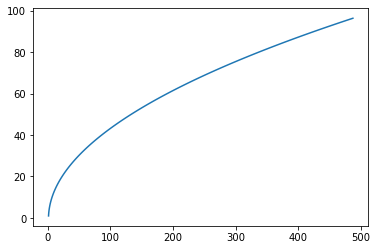

[140] loss: 246749.688


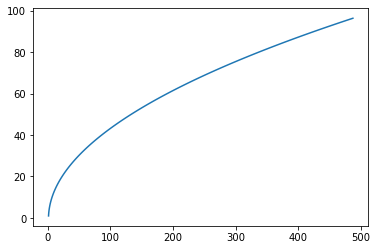

[141] loss: 246749.688


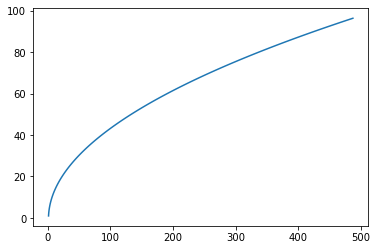

[142] loss: 246749.688


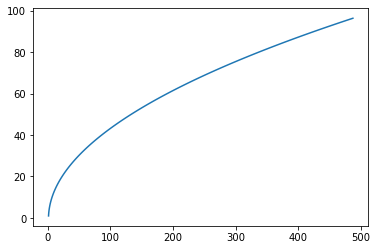

[143] loss: 246749.688


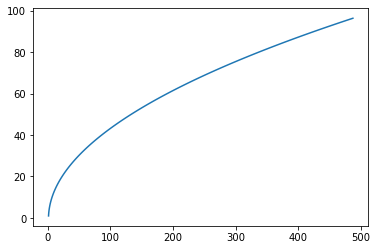

[144] loss: 246749.688


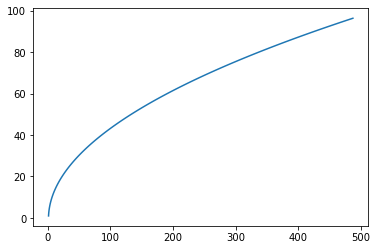

[145] loss: 246749.688


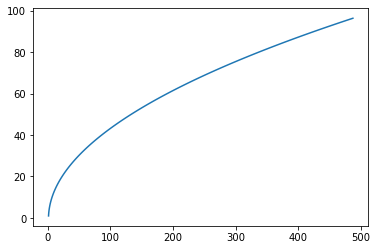

[146] loss: 246749.688


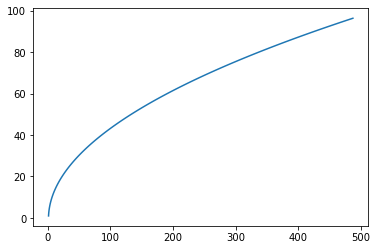

[147] loss: 246749.688


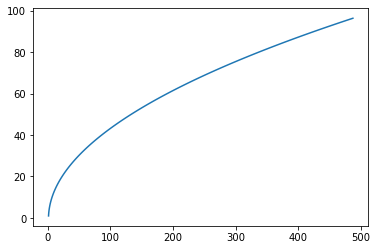

[148] loss: 246749.688


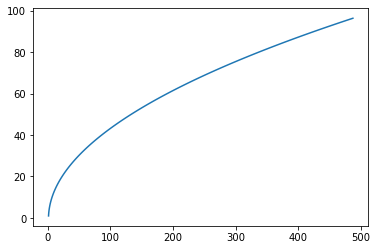

[149] loss: 246749.688


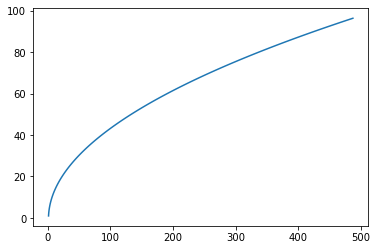

[150] loss: 246749.688


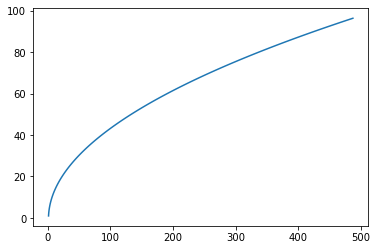

[151] loss: 246749.688


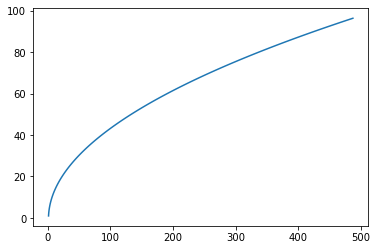

[152] loss: 246749.688


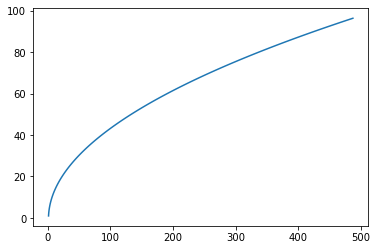

[153] loss: 246749.688


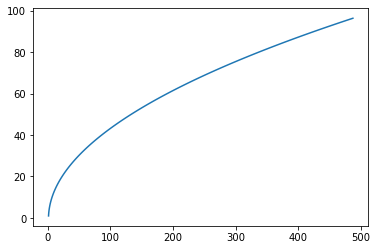

[154] loss: 246749.688


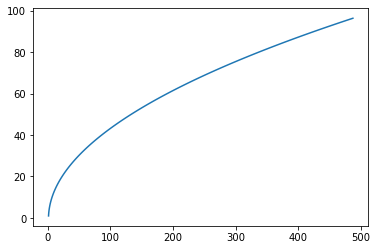

[155] loss: 246749.688


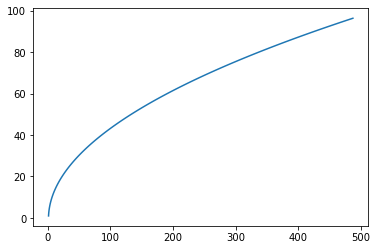

[156] loss: 246749.688


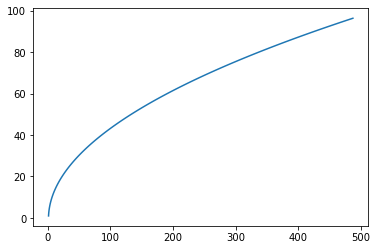

[157] loss: 246749.688


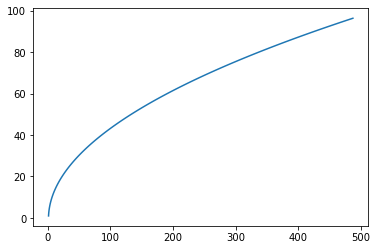

[158] loss: 246749.688


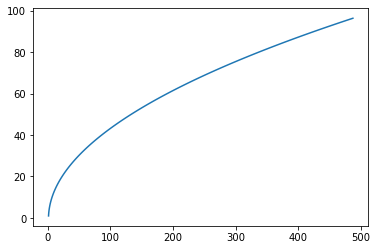

[159] loss: 246749.688


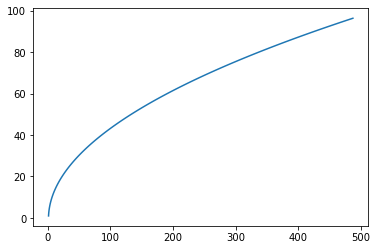

[160] loss: 246749.688


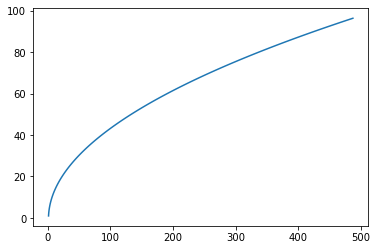

[161] loss: 246749.688


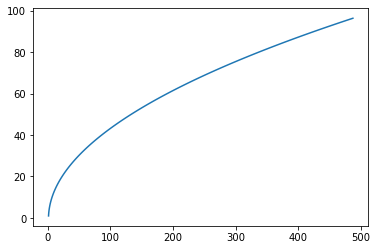

[162] loss: 246749.688


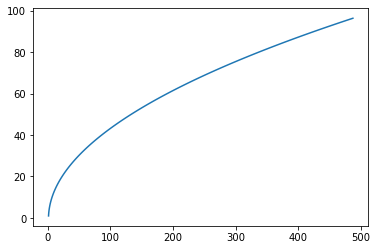

[163] loss: 246749.688


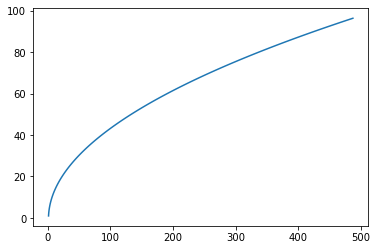

[164] loss: 246749.688


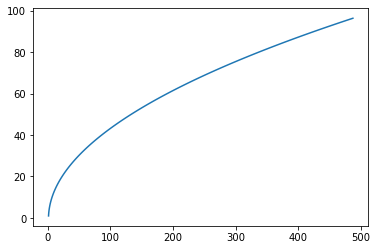

[165] loss: 246749.688


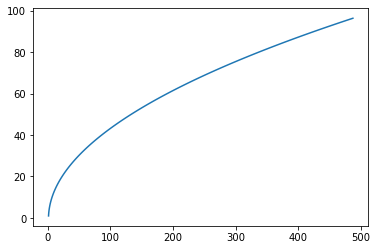

[166] loss: 246749.688


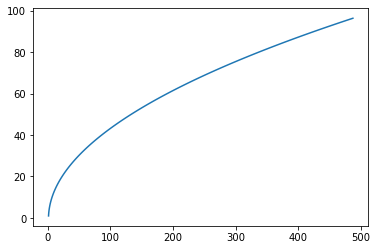

[167] loss: 246749.688


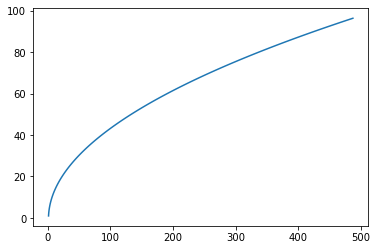

[168] loss: 246749.688


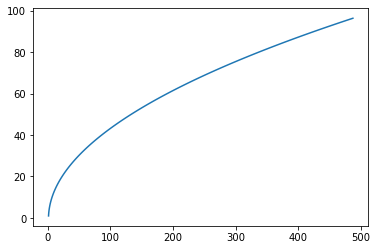

[169] loss: 246749.688


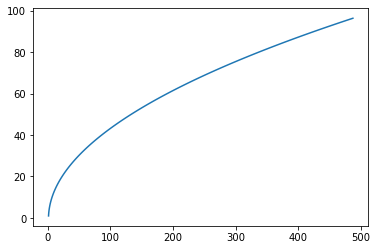

[170] loss: 246749.688


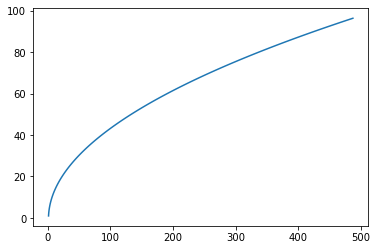

[171] loss: 246749.688


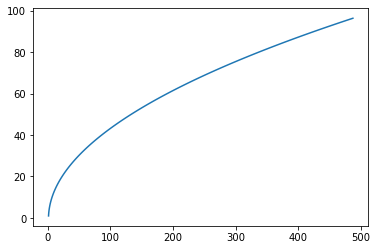

[172] loss: 246749.688


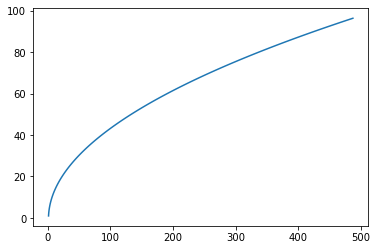

[173] loss: 246749.688


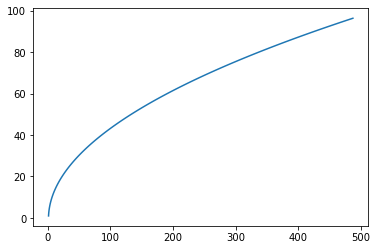

[174] loss: 246749.688


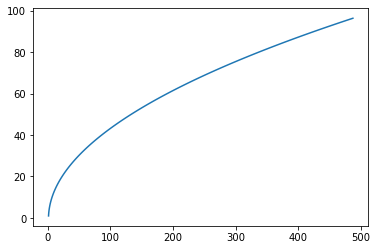

[175] loss: 246749.688


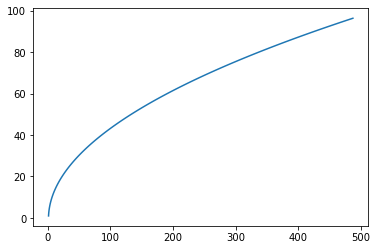

[176] loss: 246749.688


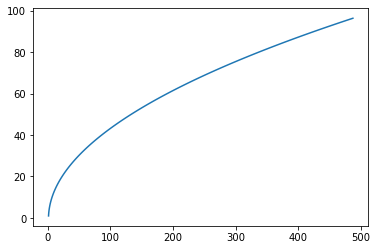

[177] loss: 246749.688


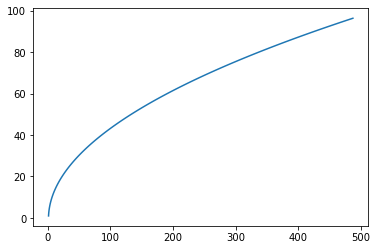

[178] loss: 246749.688


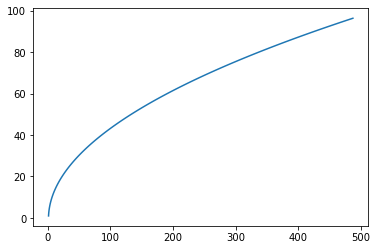

[179] loss: 246749.688


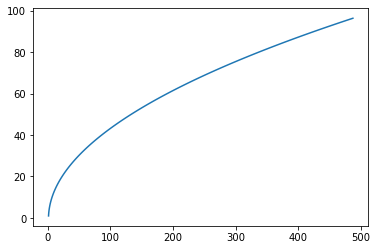

[180] loss: 246749.688


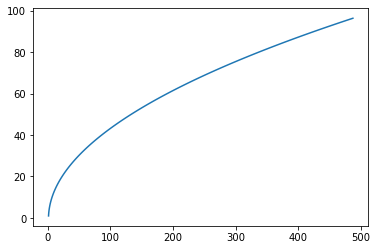

[181] loss: 246749.688


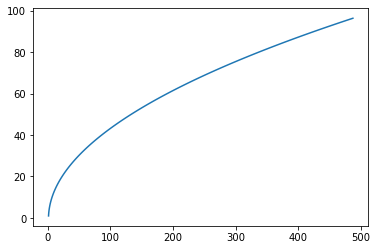

[182] loss: 246749.656


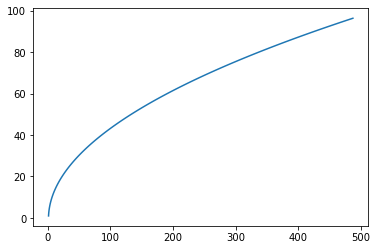

[183] loss: 246749.656


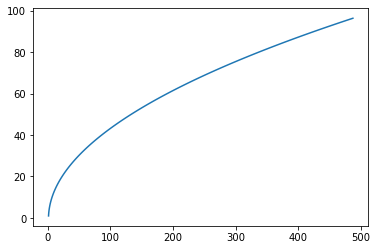

[184] loss: 246749.656


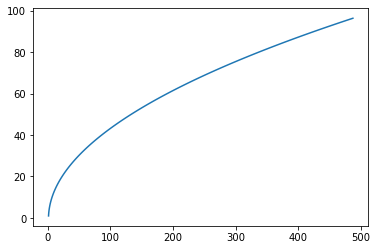

[185] loss: 246749.656


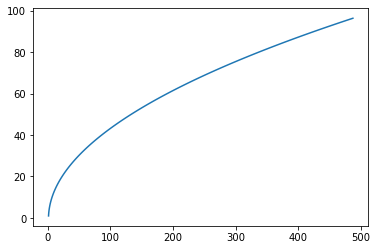

[186] loss: 246749.656


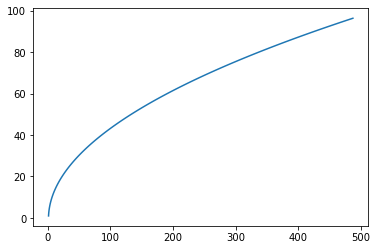

[187] loss: 246749.656


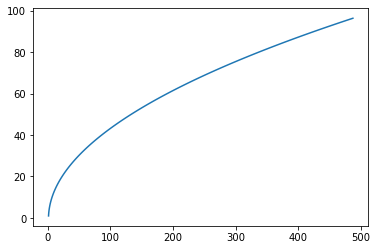

[188] loss: 246749.656


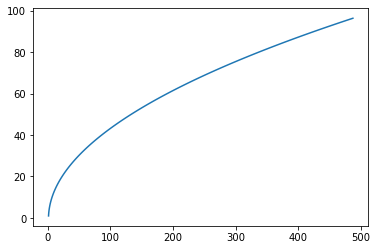

[189] loss: 246749.656


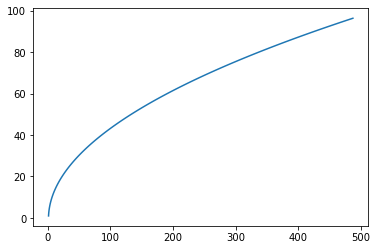

[190] loss: 246749.656


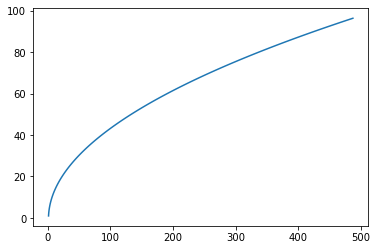

[191] loss: 246749.656


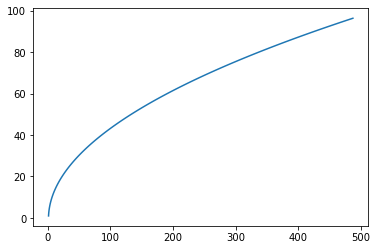

[192] loss: 246749.656


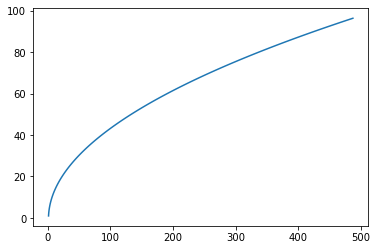

[193] loss: 246749.656


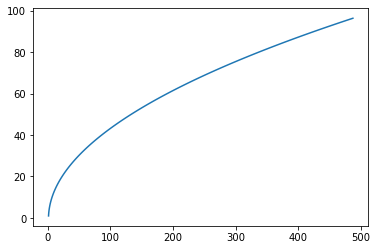

[194] loss: 246749.656


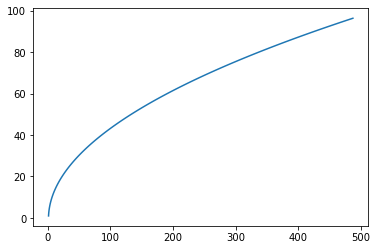

[195] loss: 246749.656


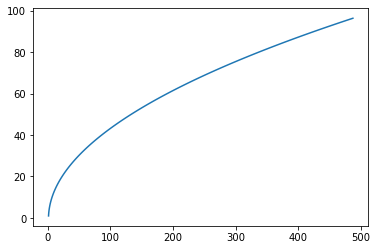

[196] loss: 246749.656


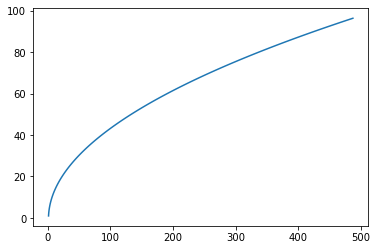

[197] loss: 246749.656


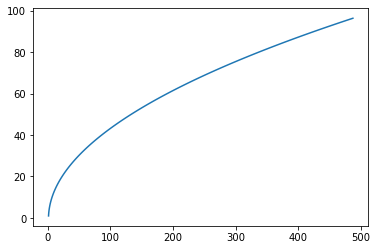

[198] loss: 246749.656


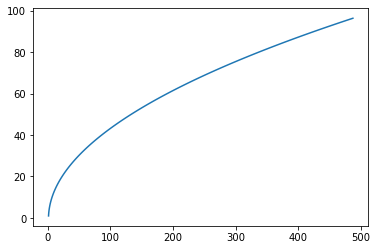

[199] loss: 246749.656


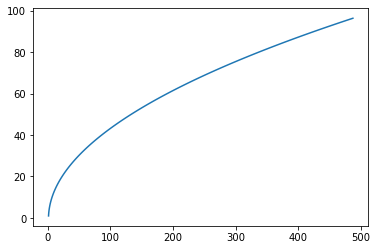

[200] loss: 246749.656


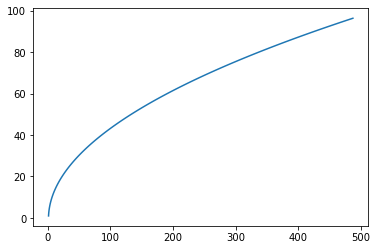

[201] loss: 246749.656


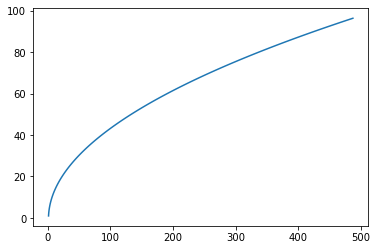

[202] loss: 246749.656


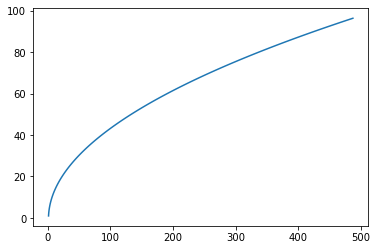

[203] loss: 246749.656


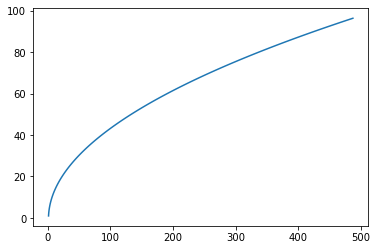

[204] loss: 246749.656


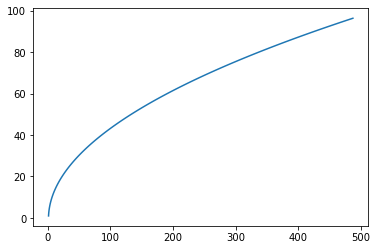

[205] loss: 246749.656


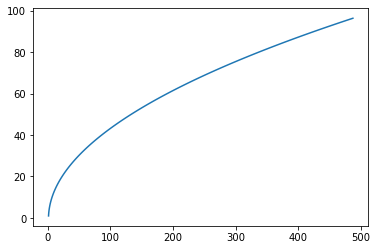

[206] loss: 246749.656


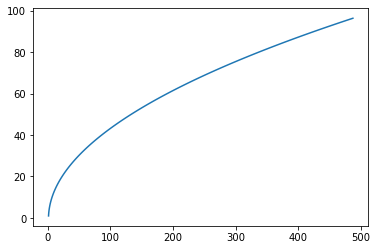

[207] loss: 246749.656


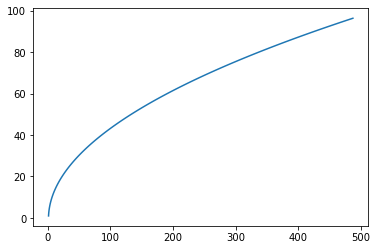

[208] loss: 246749.656


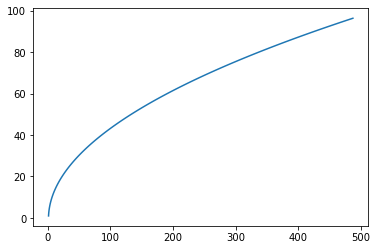

[209] loss: 246749.656


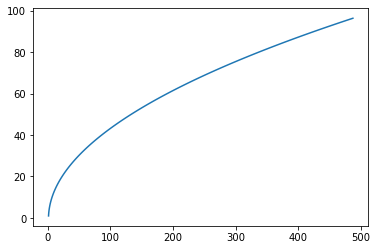

[210] loss: 246749.656


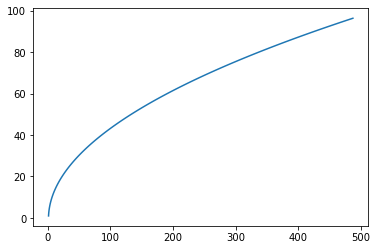

[211] loss: 246749.656


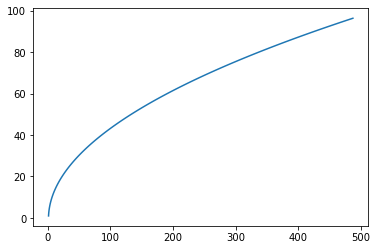

[212] loss: 246749.656


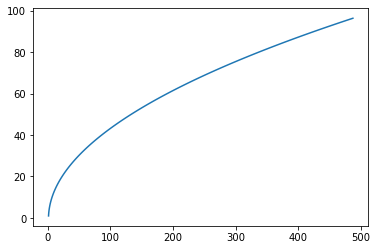

[213] loss: 246749.656


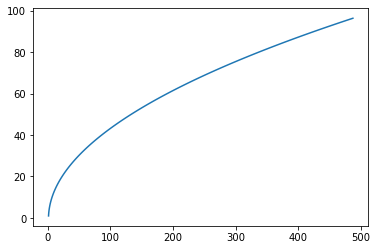

[214] loss: 246749.656


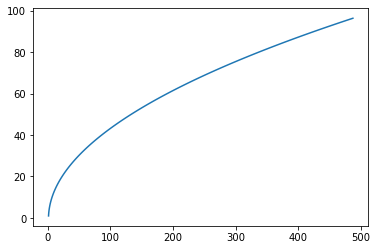

[215] loss: 246749.625


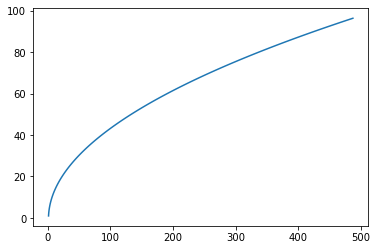

[216] loss: 246749.625


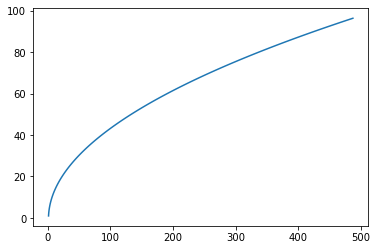

[217] loss: 246749.625


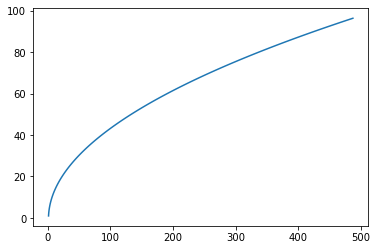

[218] loss: 246749.625


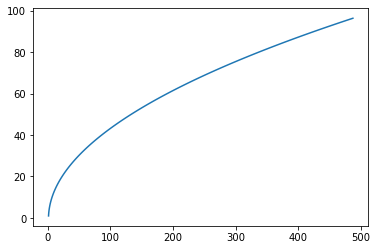

[219] loss: 246749.625


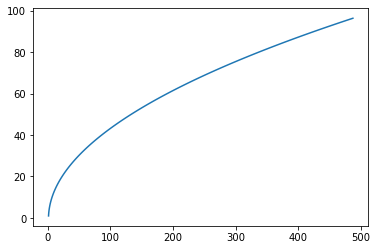

[220] loss: 246749.625


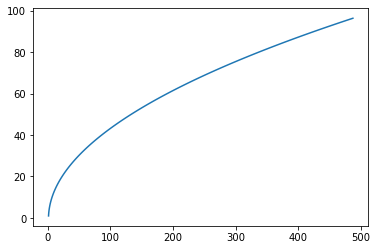

[221] loss: 246749.625


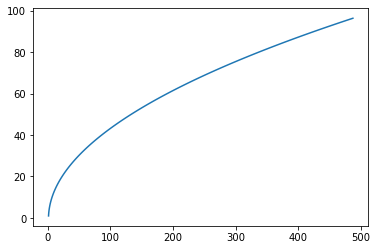

[222] loss: 246749.625


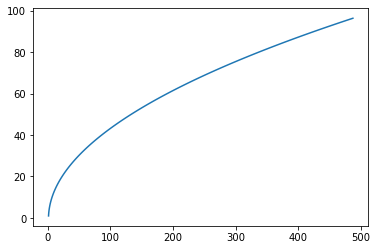

[223] loss: 246749.625


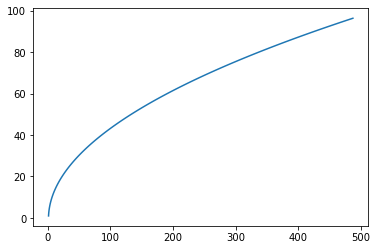

[224] loss: 246749.625


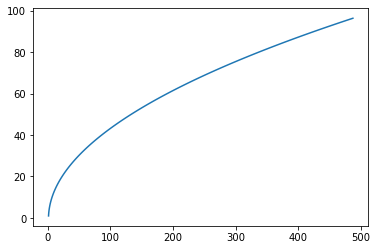

[225] loss: 246749.625


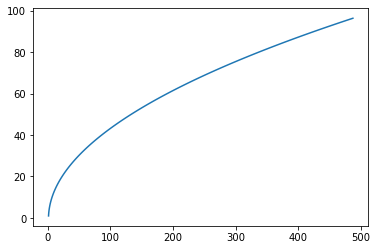

[226] loss: 246749.625


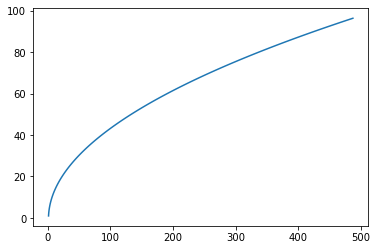

[227] loss: 246749.625


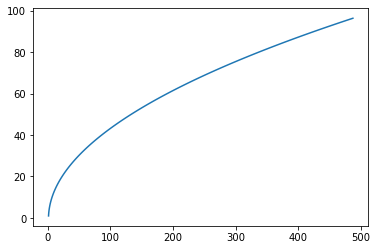

[228] loss: 246749.625


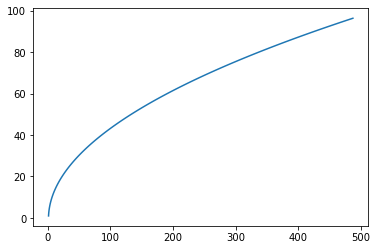

[229] loss: 246749.625


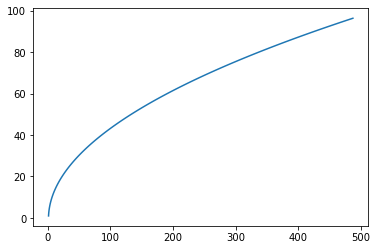

[230] loss: 246749.625


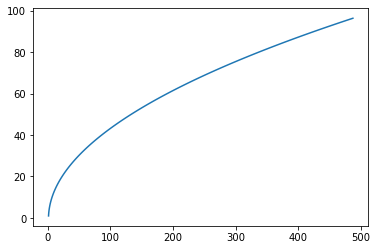

[231] loss: 246749.625


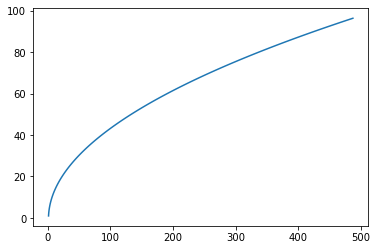

[232] loss: 246749.625


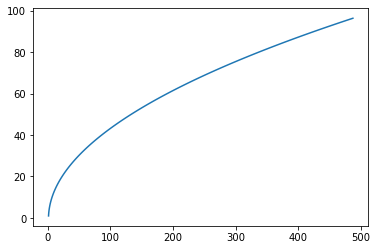

[233] loss: 246749.625


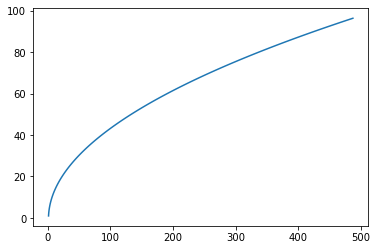

[234] loss: 246749.625


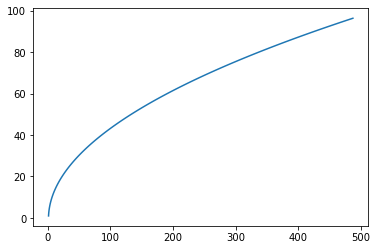

[235] loss: 246749.625


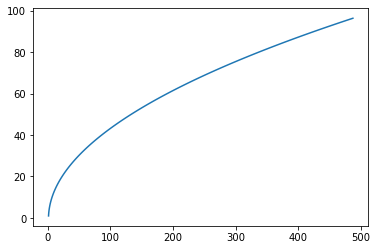

[236] loss: 246749.625


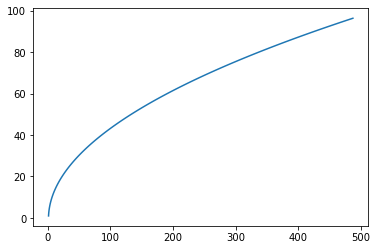

[237] loss: 246749.625


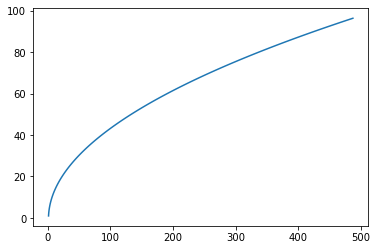

[238] loss: 246749.625


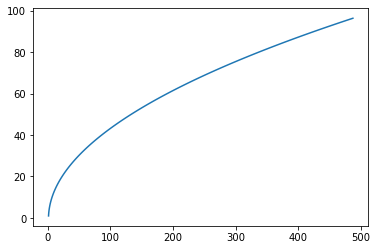

[239] loss: 246749.625


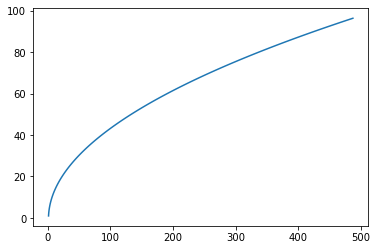

[240] loss: 246749.625


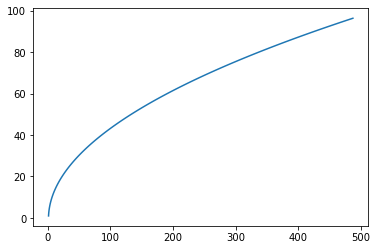

[241] loss: 246749.625


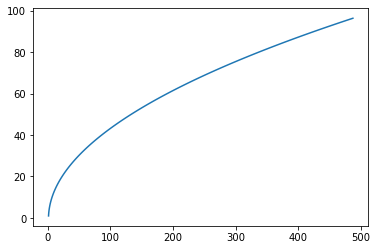

[242] loss: 246749.625


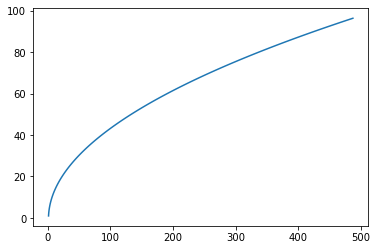

[243] loss: 246749.625


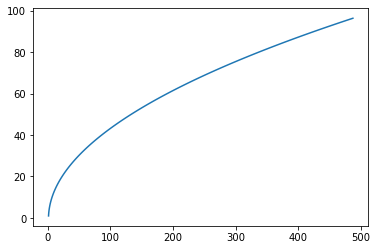

[244] loss: 246749.625


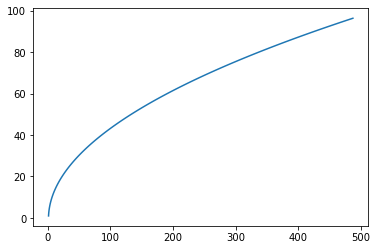

[245] loss: 246749.625


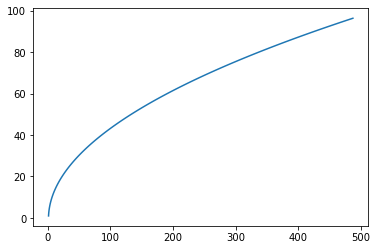

[246] loss: 246749.625


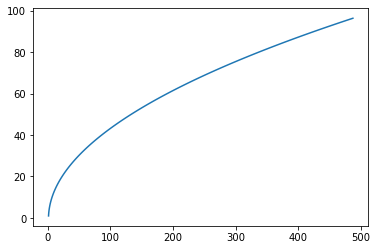

[247] loss: 246749.625


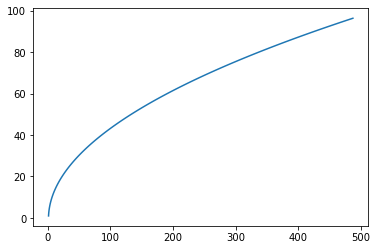

[248] loss: 246749.625


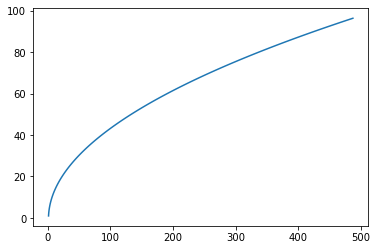

[249] loss: 246749.625


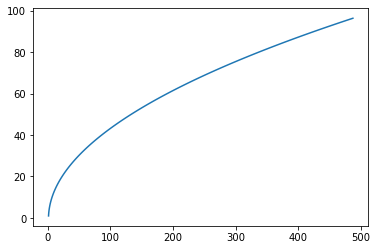

[250] loss: 246749.625


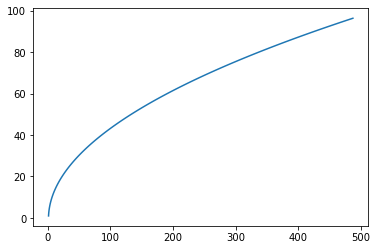

[251] loss: 246749.625


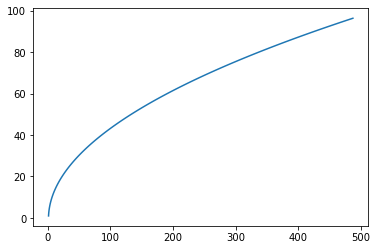

[252] loss: 246749.625


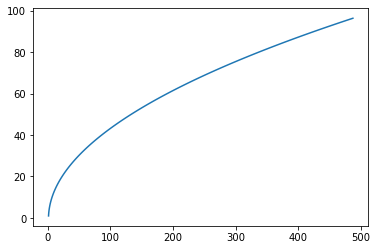

[253] loss: 246749.625


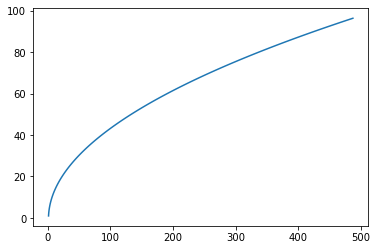

[254] loss: 246749.625


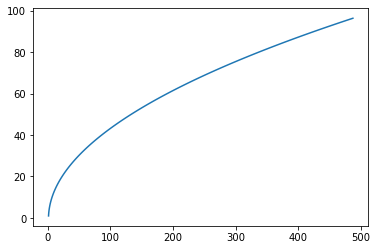

[255] loss: 246749.625


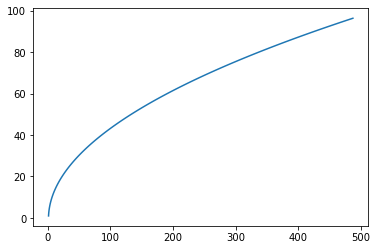

[256] loss: 246749.625


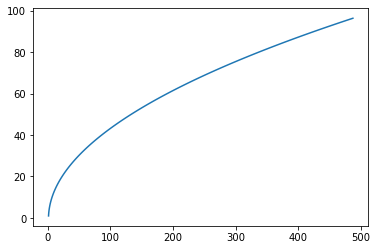

[257] loss: 246749.625


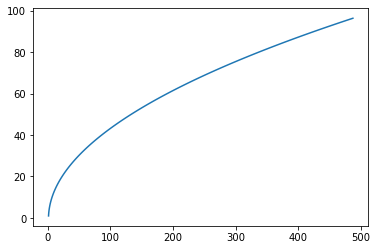

[258] loss: 246749.625


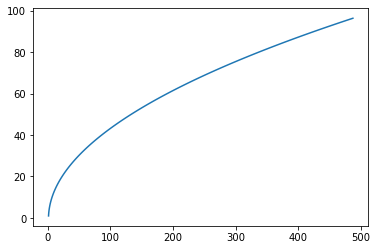

[259] loss: 246749.625


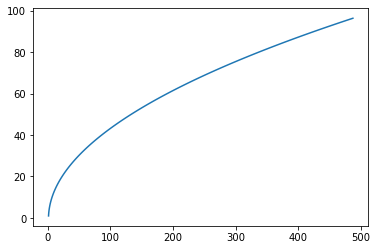

[260] loss: 246749.625


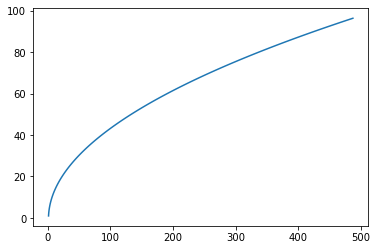

[261] loss: 246749.625


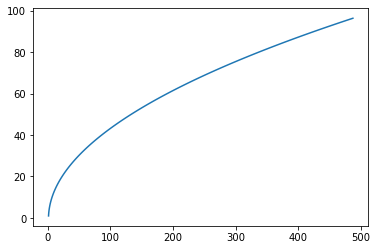

[262] loss: 246749.625


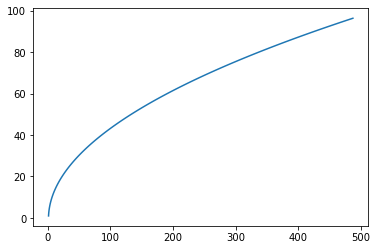

[263] loss: 246749.625


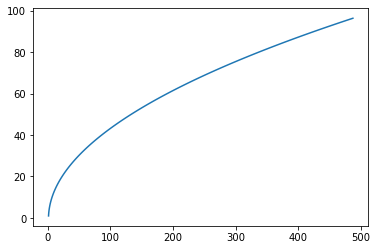

[264] loss: 246749.625


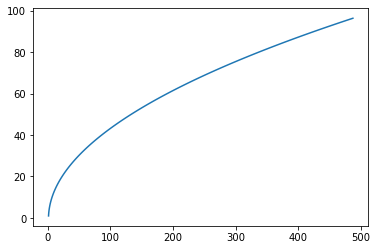

[265] loss: 246749.625


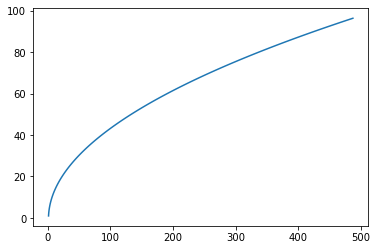

[266] loss: 246749.625


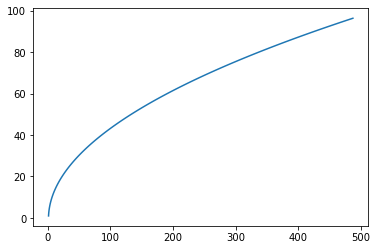

[267] loss: 246749.625


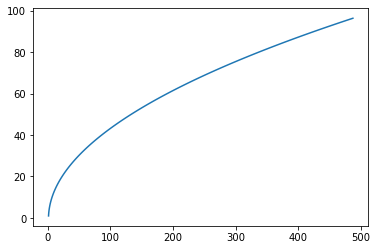

[268] loss: 246749.625


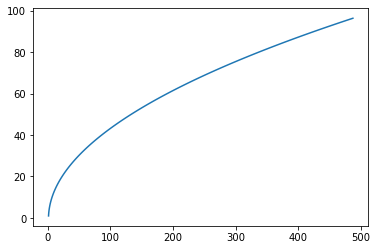

[269] loss: 246749.625


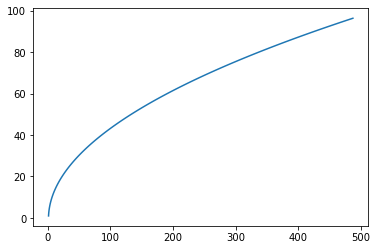

[270] loss: 246749.625


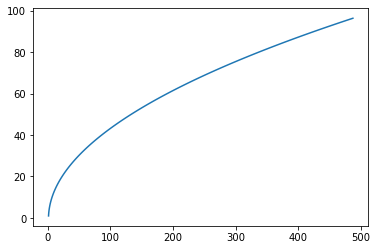

[271] loss: 246749.625


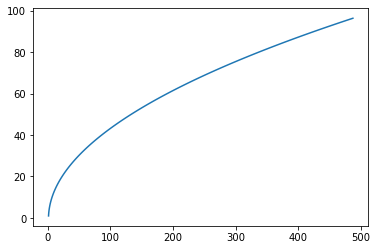

[272] loss: 246749.625


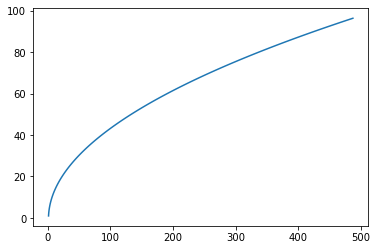

[273] loss: 246749.625


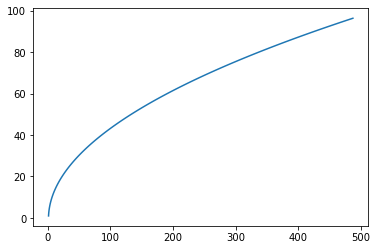

[274] loss: 246749.625


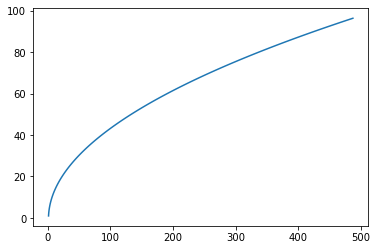

[275] loss: 246749.625


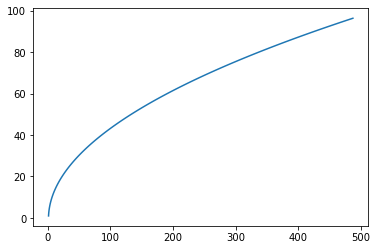

[276] loss: 246749.625


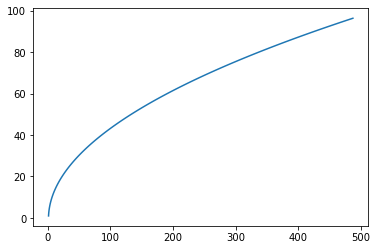

[277] loss: 246749.625


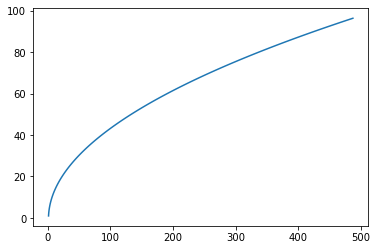

[278] loss: 246749.625


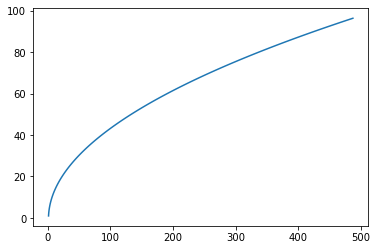

[279] loss: 246749.625


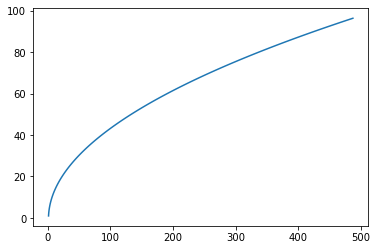

[280] loss: 246749.625


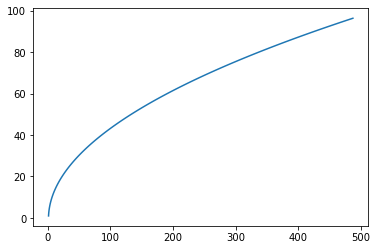

[281] loss: 246749.625


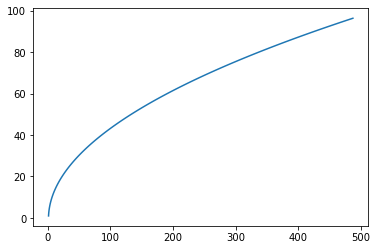

[282] loss: 246749.625


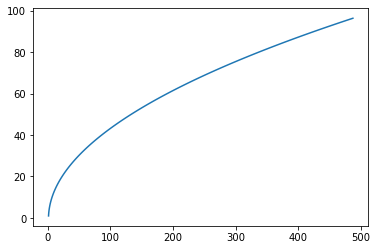

[283] loss: 246749.625


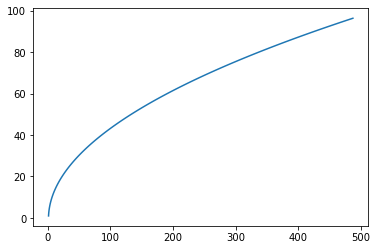

[284] loss: 246749.625


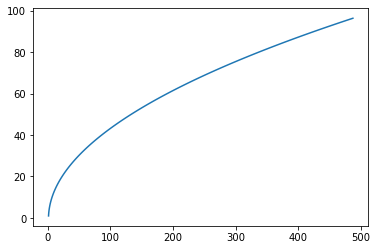

[285] loss: 246749.625


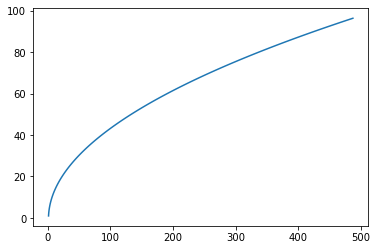

[286] loss: 246749.625


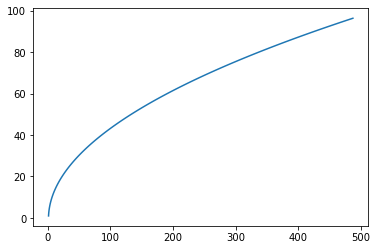

[287] loss: 246749.625


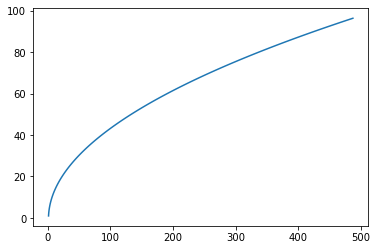

[288] loss: 246749.625


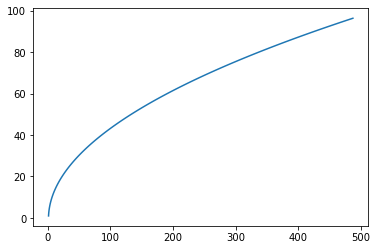

[289] loss: 246749.625


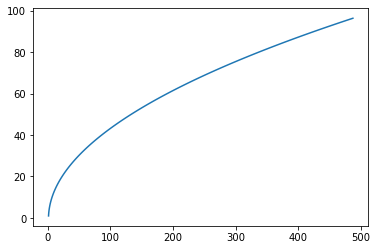

[290] loss: 246749.625


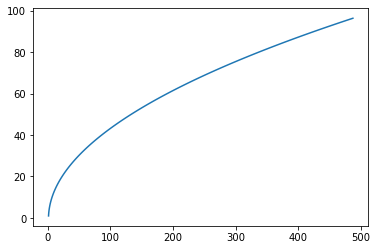

[291] loss: 246749.625


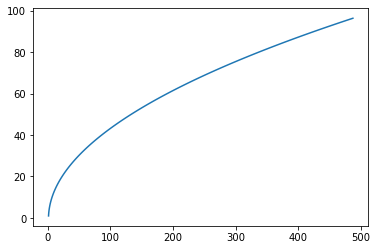

[292] loss: 246749.625


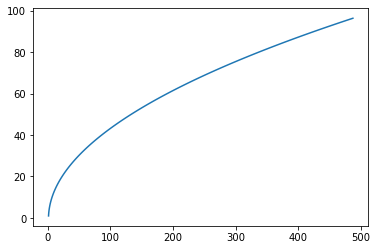

[293] loss: 246749.625


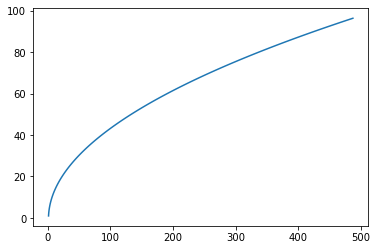

[294] loss: 246749.625


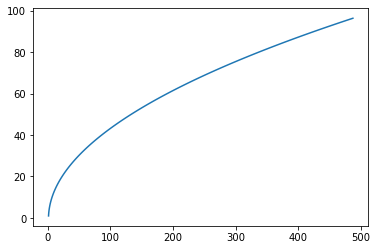

[295] loss: 246749.625


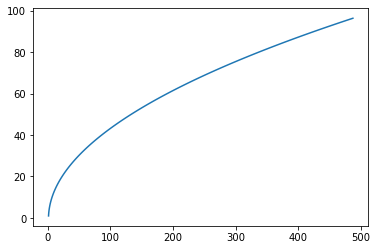

[296] loss: 246749.625


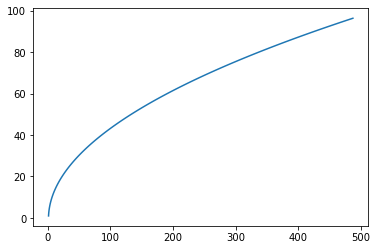

[297] loss: 246749.625


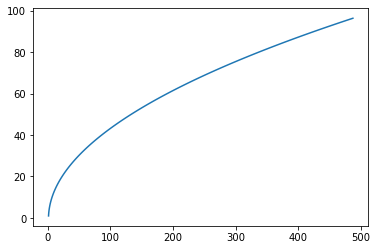

[298] loss: 246749.625


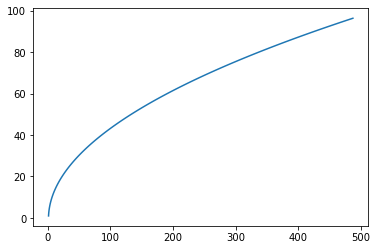

[299] loss: 246749.625


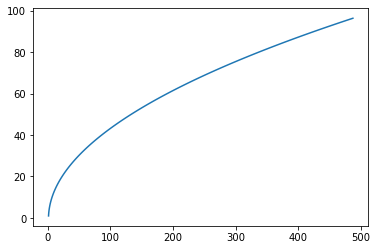

[300] loss: 246749.625


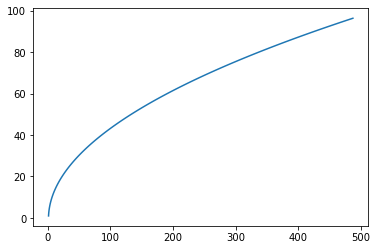

[301] loss: 246749.625


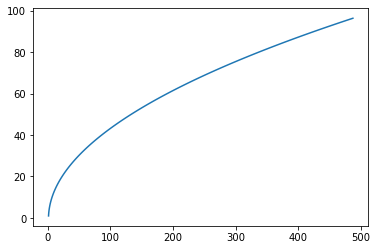

[302] loss: 246749.625


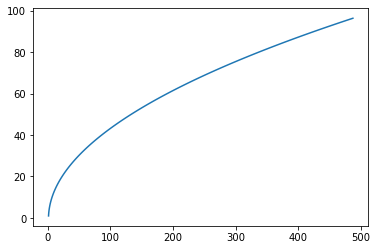

[303] loss: 246749.625


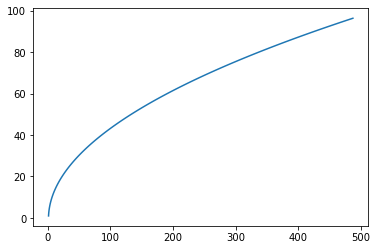

[304] loss: 246749.625


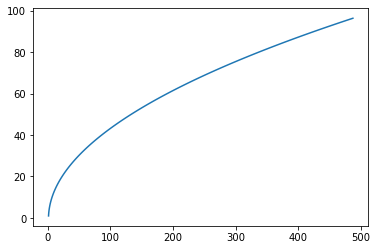

[305] loss: 246749.625


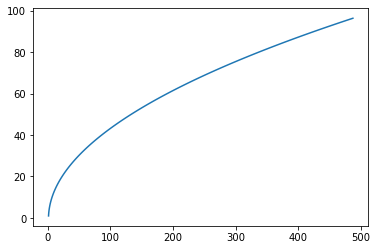

[306] loss: 246749.625


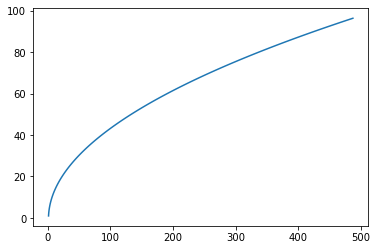

[307] loss: 246749.625


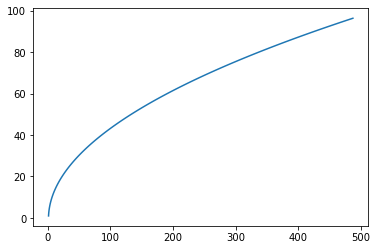

[308] loss: 246749.625


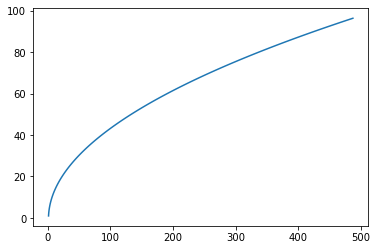

[309] loss: 246749.625


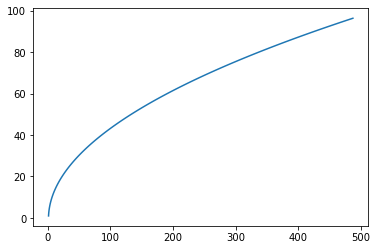

[310] loss: 246749.625


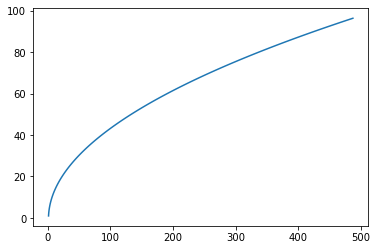

[311] loss: 246749.625


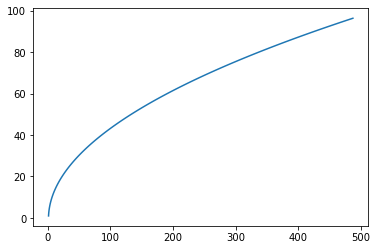

[312] loss: 246749.625


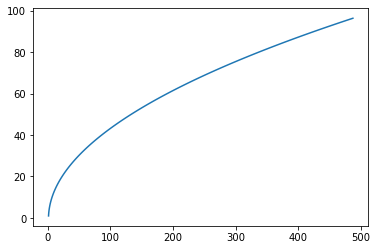

[313] loss: 246749.625


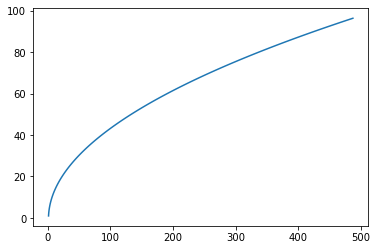

[314] loss: 246749.625


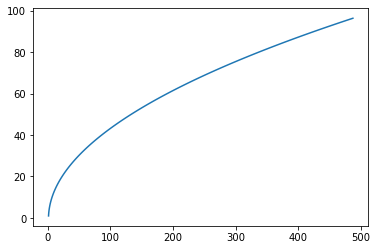

[315] loss: 246749.625


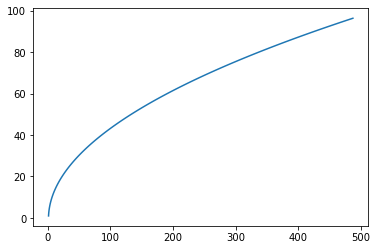

[316] loss: 246749.625


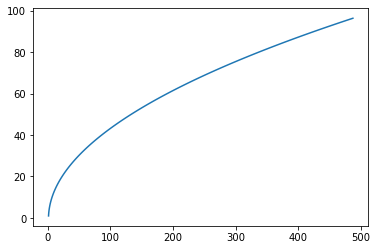

[317] loss: 246749.625


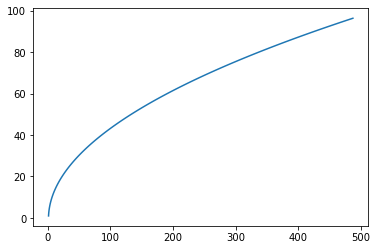

[318] loss: 246749.625


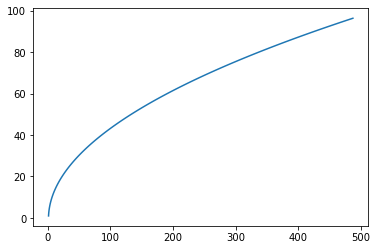

[319] loss: 246749.625


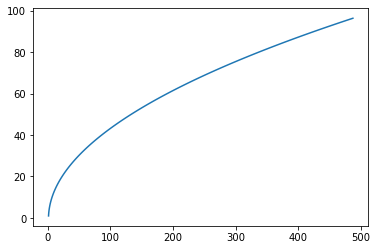

[320] loss: 246749.625


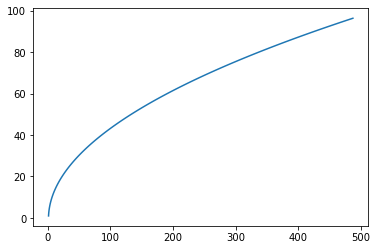

[321] loss: 246749.625


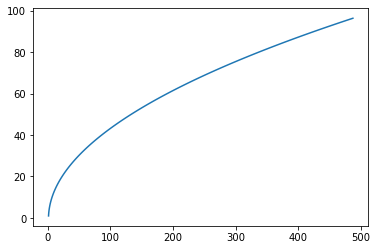

[322] loss: 246749.625


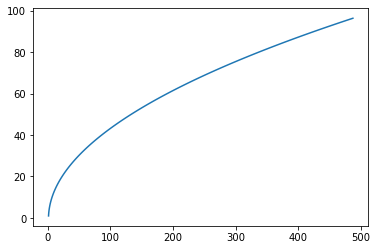

[323] loss: 246749.625


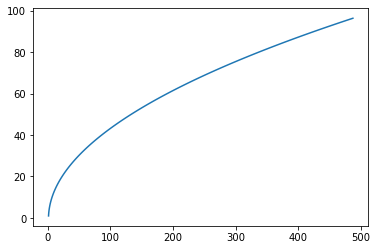

[324] loss: 246749.625


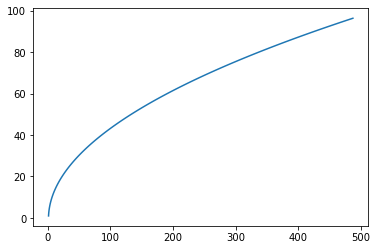

[325] loss: 246749.625


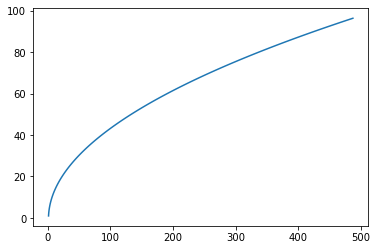

[326] loss: 246749.625


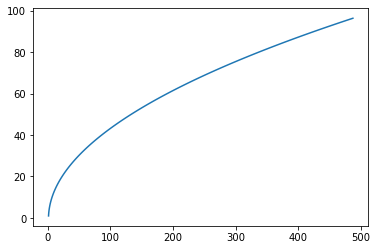

[327] loss: 246749.625


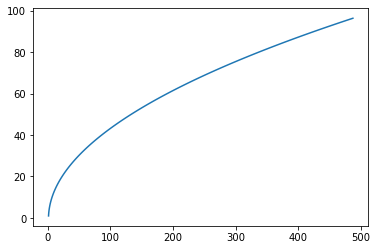

[328] loss: 246749.625


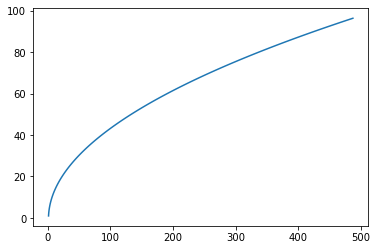

[329] loss: 246749.625


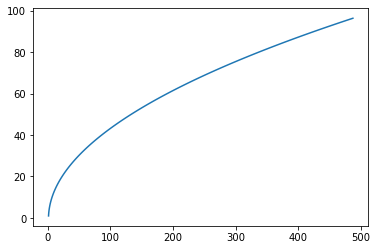

[330] loss: 246749.625


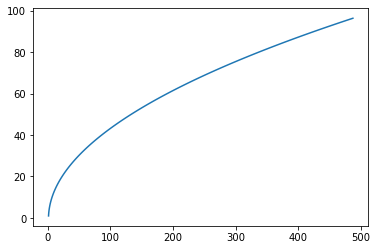

[331] loss: 246749.625


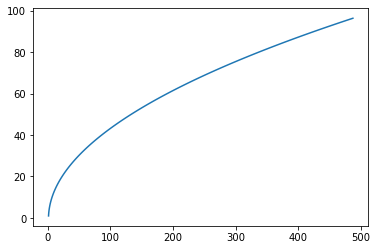

[332] loss: 246749.625


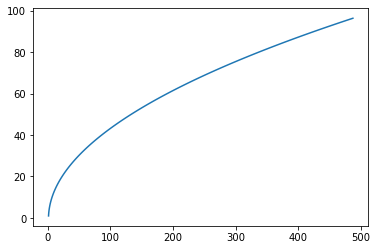

[333] loss: 246749.625


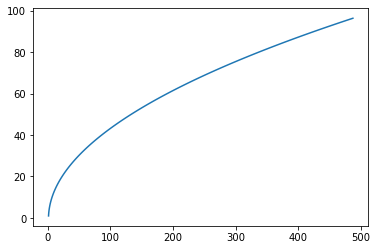

[334] loss: 246749.625


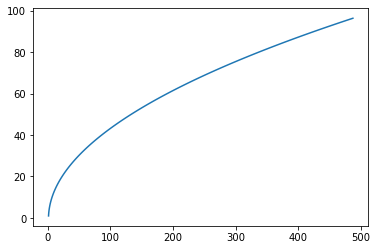

[335] loss: 246749.625


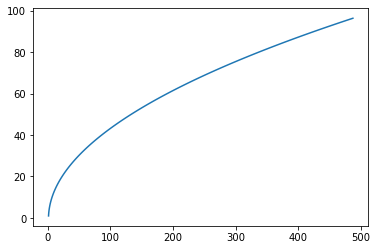

[336] loss: 246749.625


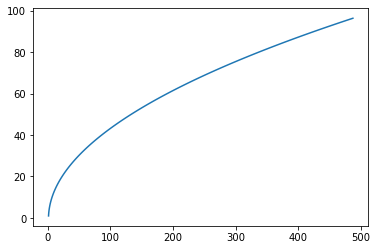

[337] loss: 246749.625


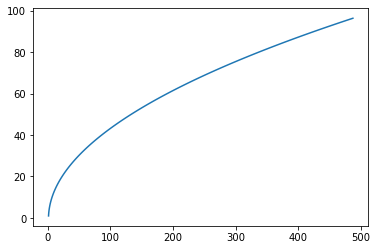

[338] loss: 246749.625


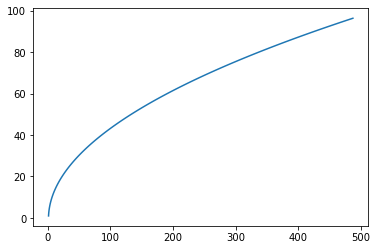

[339] loss: 246749.625


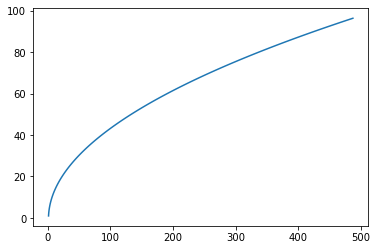

[340] loss: 246749.625


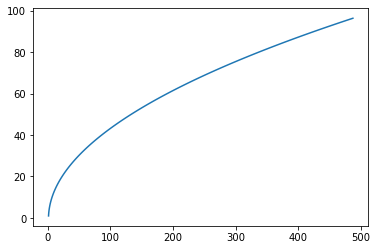

[341] loss: 246749.625


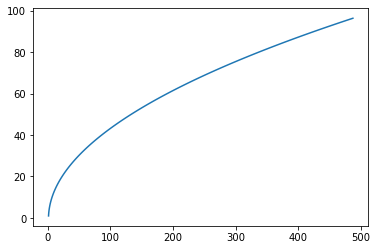

[342] loss: 246749.625


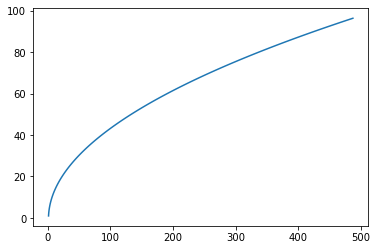

[343] loss: 246749.625


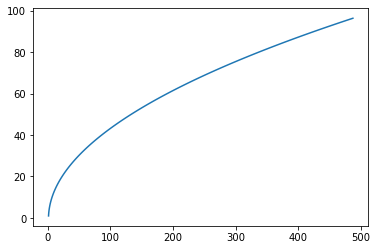

[344] loss: 246749.625


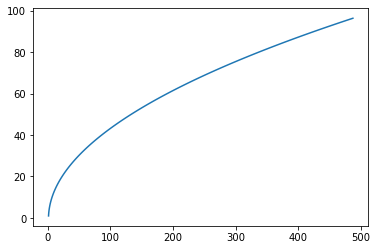

[345] loss: 246749.625


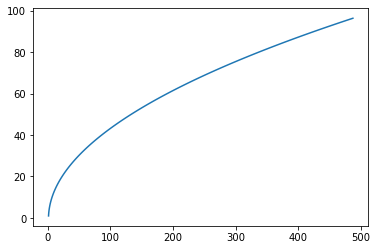

[346] loss: 246749.625


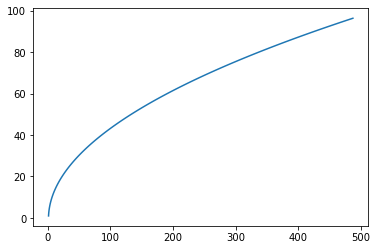

[347] loss: 246749.625


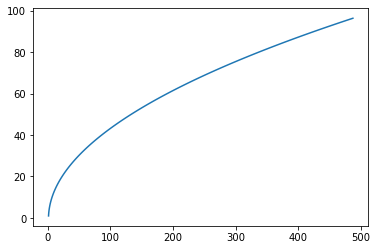

[348] loss: 246749.625


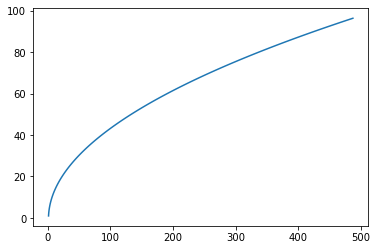

[349] loss: 246749.625


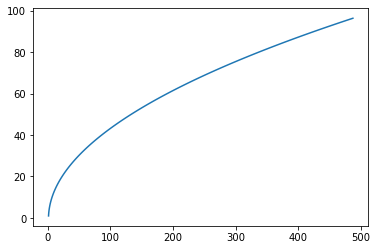

[350] loss: 246749.625


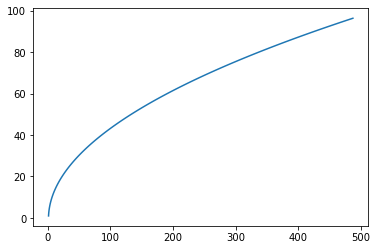

[351] loss: 246749.625


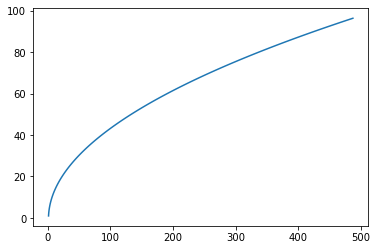

[352] loss: 246749.625


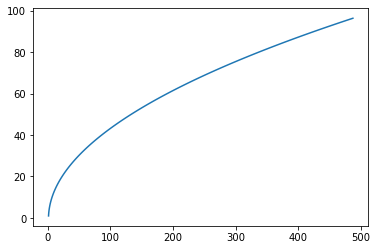

[353] loss: 246749.625


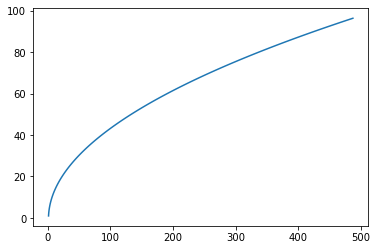

[354] loss: 246749.625


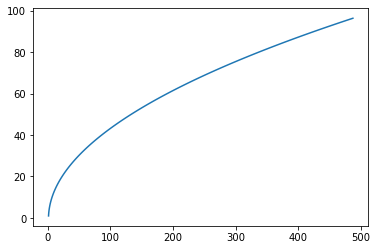

[355] loss: 246749.625


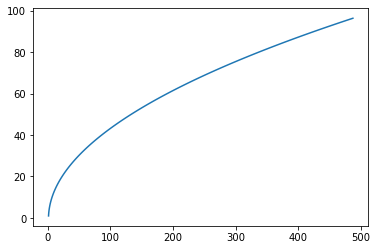

[356] loss: 246749.625


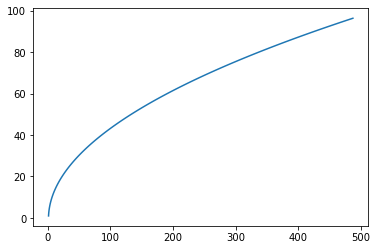

[357] loss: 246749.625


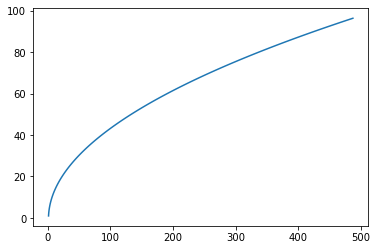

[358] loss: 246749.625


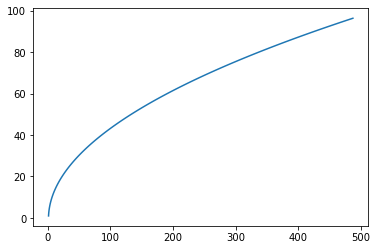

[359] loss: 246749.625


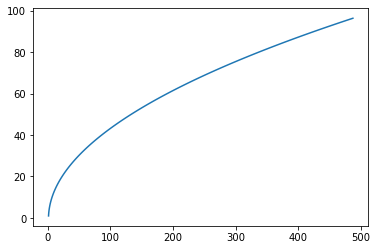

[360] loss: 246749.625


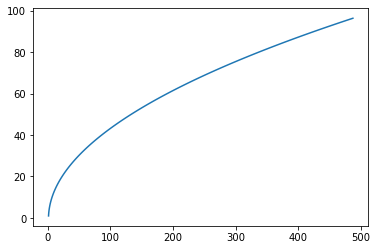

[361] loss: 246749.625


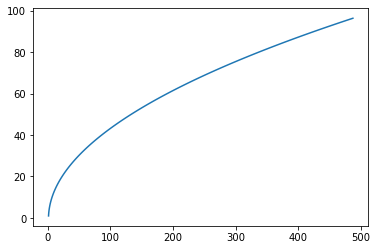

[362] loss: 246749.625


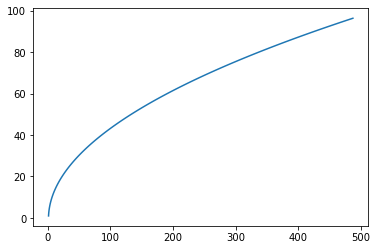

[363] loss: 246749.625


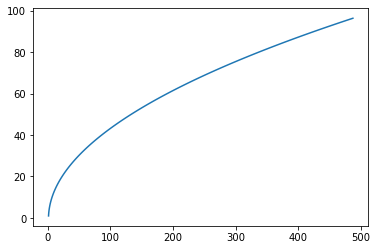

[364] loss: 246749.625


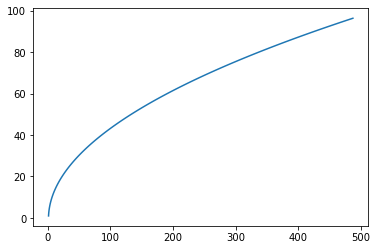

[365] loss: 246749.625


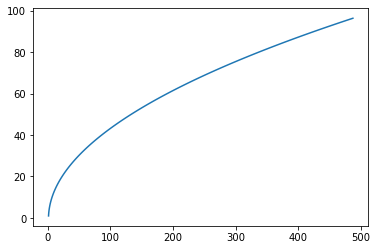

[366] loss: 246749.625


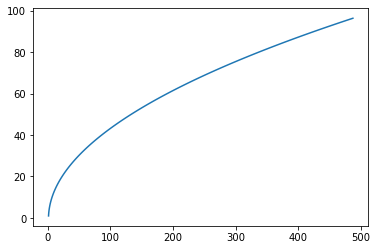

[367] loss: 246749.625


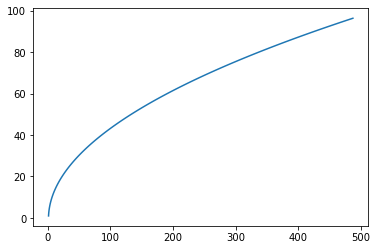

[368] loss: 246749.625


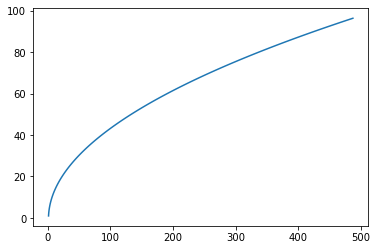

[369] loss: 246749.625


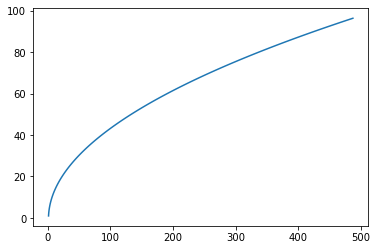

[370] loss: 246749.625


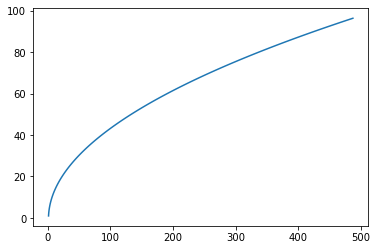

[371] loss: 246749.625


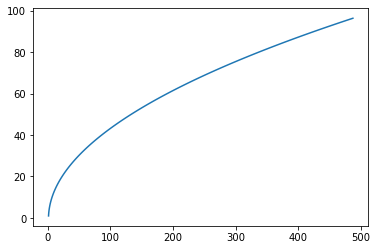

[372] loss: 246749.625


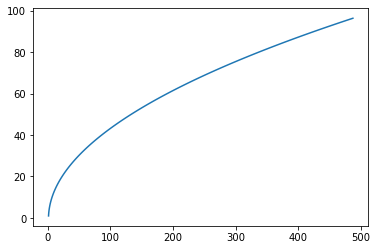

[373] loss: 246749.625


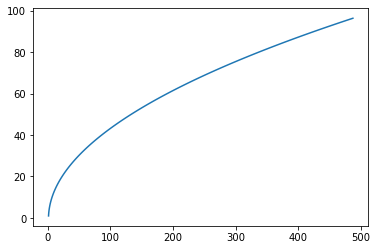

[374] loss: 246749.625


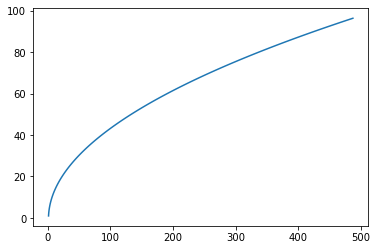

[375] loss: 246749.625


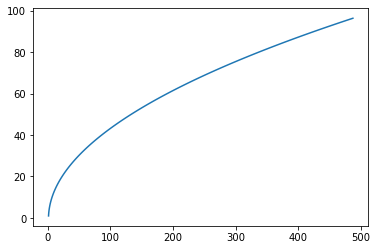

[376] loss: 246749.625


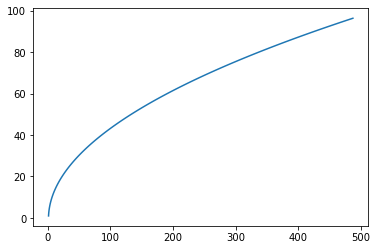

[377] loss: 246749.625


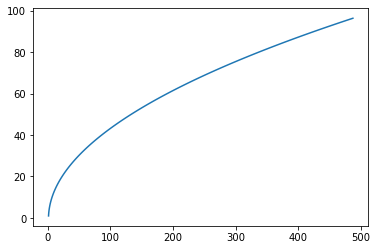

[378] loss: 246749.625


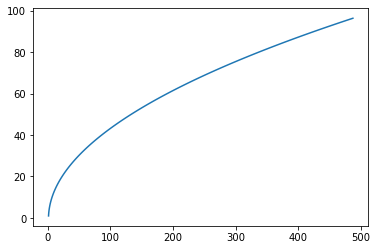

[379] loss: 246749.625


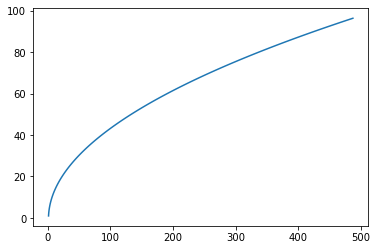

[380] loss: 246749.625


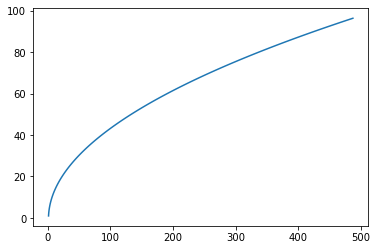

[381] loss: 246749.625


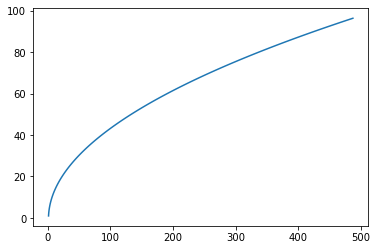

[382] loss: 246749.625


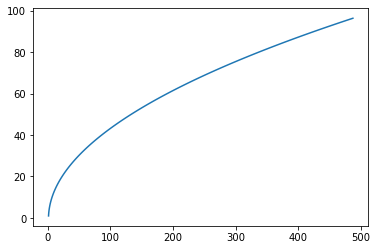

[383] loss: 246749.625


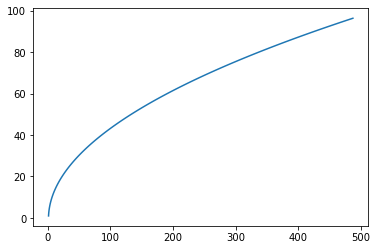

[384] loss: 246749.625


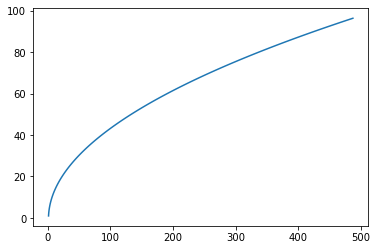

[385] loss: 246749.625


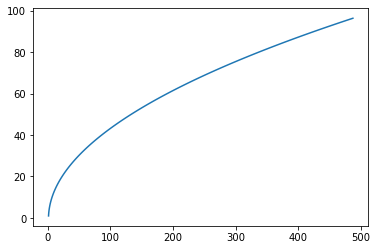

[386] loss: 246749.625


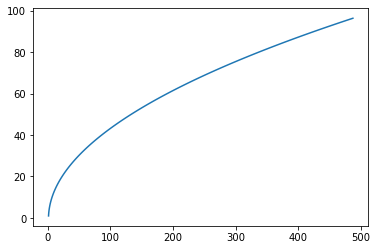

[387] loss: 246749.625


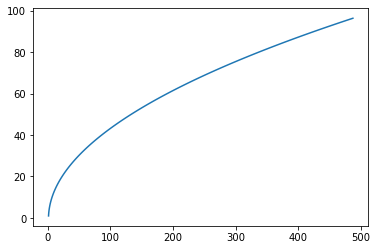

[388] loss: 246749.625


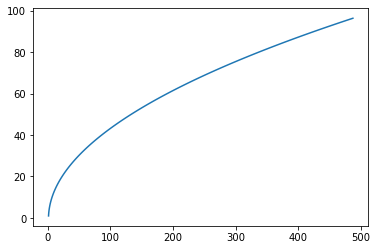

[389] loss: 246749.625


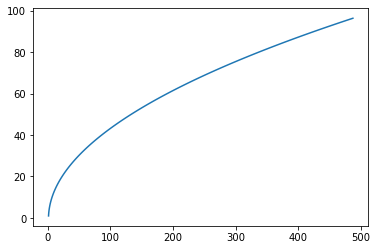

[390] loss: 246749.625


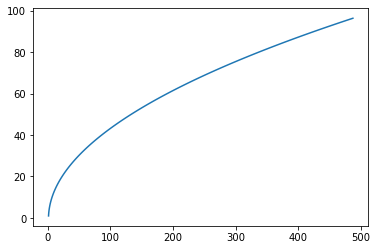

[391] loss: 246749.625


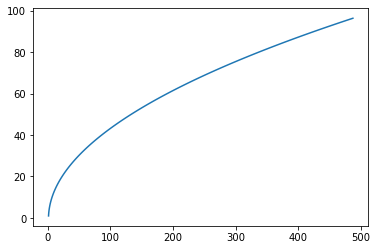

[392] loss: 246749.625


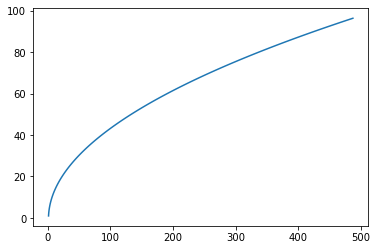

[393] loss: 246749.625


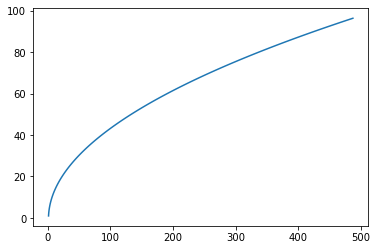

[394] loss: 246749.625


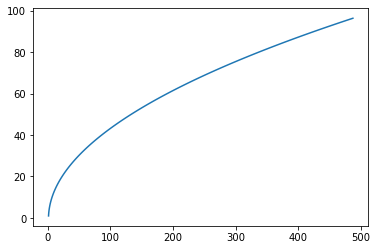

[395] loss: 246749.625


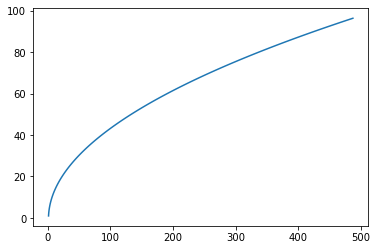

[396] loss: 246749.625


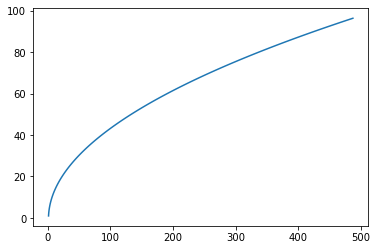

[397] loss: 246749.625


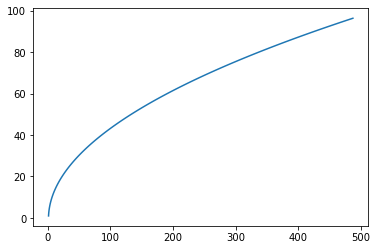

[398] loss: 246749.625


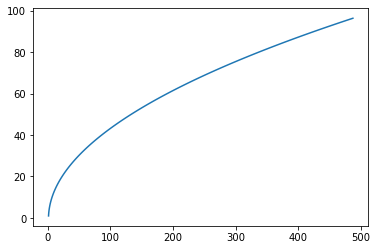

[399] loss: 246749.625


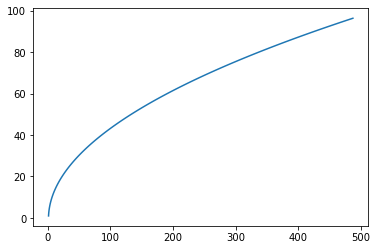

[400] loss: 246749.625


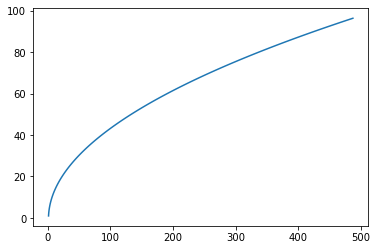

In [48]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem

## Better

In [245]:
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 9.81  # gravity constant
BOOST_ACCEL = 10.0  # thrust constant
rho = 1.25 #density in kg/m^3
CD = 1.14 # coefficient of drag
CL = 0.8 # coefficient of lift
A = 63.62 #m^2 ,Dia = 9m

# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: Main engine thrust(z),Side thrust(x) and Drag
        action[0]: thrust in x direction.
        action[1]: thrust in z direction. 
                𝑥 = 𝐻𝑜𝑟𝑖𝑧𝑜𝑛𝑡𝑎𝑙 𝑃𝑜𝑠𝑖𝑡𝑖𝑜𝑛 𝑜𝑓 𝑡ℎ𝑒 𝑅𝑜𝑐𝑘𝑒𝑡
                𝑧 = 𝑉𝑒𝑟𝑡𝑖𝑐𝑎𝑙 𝑃𝑜𝑠𝑖𝑡𝑖𝑜𝑛 𝑜𝑓 𝑡ℎ𝑒 𝑅𝑜𝑐𝑘𝑒
        action[2]: Drag in z direction = 0.5*rho*velocity^2*A*CD.range (1,0) 
        
        states:
        state[0] = x
        state[1] = thrust_x
        state[2] = z
        state[3] = thrust_z
        state[4] = z1
        state[5] = D
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0.,0.,0.,0.,0.,0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust and Drag
        
        thrust_x = action[0]
        thrust_z = action[1]
        drag_y   = action[2]*0.5*rho*A*CD
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state_thrust_x = GRAVITY_ACCEL * FRAME_TIME * t.tensor([0., 1., 0., 0., 0., 0.]) * thrust_x
        delta_state_thrust_z = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 1., 0., 0.]) * thrust_z
        delta_state_drag = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 0., 0., 1.]) * drag_y

        # Update velocity
        state = state + delta_state_thrust_z + delta_state_thrust_x - delta_state_drag
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME,0.,0., 0., 0.],
                            [0., 1.,0.,0.,0.,0.],
                             [0.,0.,1.,FRAME_TIME,0.,0.],
                             [0.,0.,0.,1.,0.,0.],
                             [0.,0.,0.,0.,1.,FRAME_TIME],
                             [0.,0.,0.,0.,0.,1.]])
        
        state = t.matmul(step_mat, state)

        return state


In [246]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [247]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # initial position of x,z,thrust and drag
        state = [10., -1., 10., 1., 5., 1.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2 + state[4]**2 - state[5]**2

In [248]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

niter = [] # No: of iterations
llist = [] # List of loss
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            llist.append(loss.detach())
            niter.append(epoch+1)
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            if epoch % 10 == 0:
                self.visualize(epoch,loss)


    def visualize(self,epoch,loss):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
    
        x = data[:, 0]
        z = data[:, 2]
        T = range(self.simulation.T)
        velocity_x  = data[:, 1]
        velocity_z  = data[:, 3]
        data1 = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        thrust_x  = data1[:, 1]
        thrust_z  = data1[:, 3]
        z1 = data1[:, 4]
        drag_y = data1[:, 5]

        fig,ax = plt.subplots(1, 4, figsize=(24, 6))
        
        ax[0].plot(x, z)
        #ax[0].plot(20, 30, '-bo', c='r', label='initial position')
        #ax[0].plot(0, 0, '-ro', c='b', label='landing position')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('z')
        ax[0].set(title='Rocket Position')
        #ax[0].legend()
        
        ax[1].plot(T, velocity_x, c='b', label='x velocity')
        ax[1].plot(T, velocity_z, c='r', label='z velocity')
        ax[1].set_xlabel('frame (0.1s)')
        ax[1].set_ylabel('v (m/s)')
        ax[1].set(title='Velocity plot')
        ax[1].legend()
        
        ax[2].plot(T, thrust_x, c='b', label='x thrust')
        ax[2].plot(T, thrust_z, c='r', label='z thrust')
        ax[2].set_xlabel('Time frame (0.1s)')
        ax[2].set_ylabel('Thrust')
        ax[2].set(title='Thrust')
        ax[2].legend()
        
        ax[3].plot(T, drag_y, c='b', label='y Drag')
        ax[3].set_xlabel('Time frame (0.1s)')
        ax[3].set_ylabel('Drag')
        ax[3].set(title='Drag')
        
        #ax[4].plot(T, loss.sum().detach().numpy(), c='b')
        #ax[4].set_xlabel('Iterations')
        #ax[4].set_ylabel('Loss')
        #ax[4].set(title='Convergence')
                   
        fig.tight_layout()
        
        plt.show()
   

[1] loss: 134766032.000


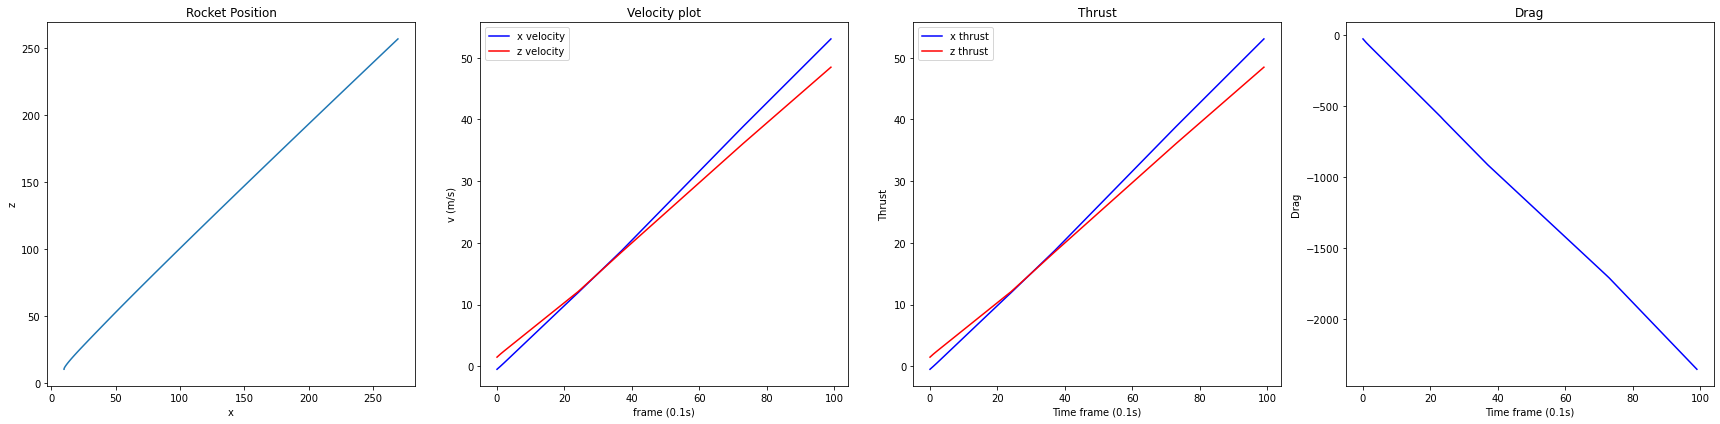

[2] loss: 128184184.000
[3] loss: 111739216.000
[4] loss: 81917808.000
[5] loss: 59449592.000
[6] loss: 29544010.000
[7] loss: 20662556.000
[8] loss: 11520647.000
[9] loss: 6975912.000
[10] loss: 5250757.000
[11] loss: 3767917.500


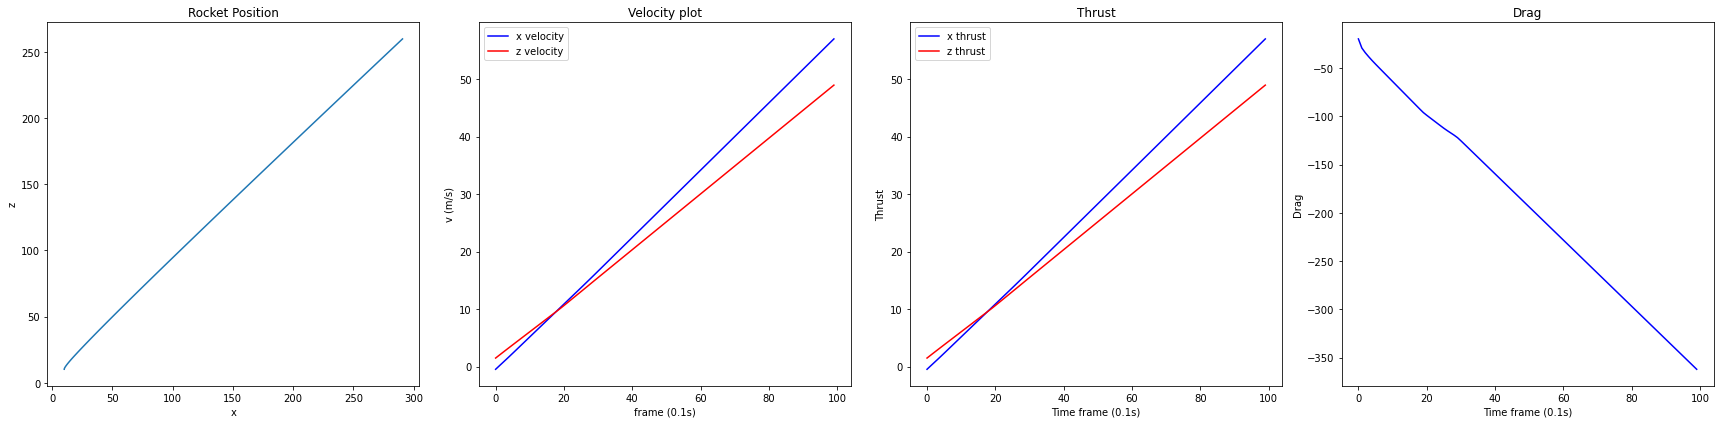

[12] loss: 2524451.000
[13] loss: 915910.438
[14] loss: 707571.375
[15] loss: 503183.125
[16] loss: 363654.938
[17] loss: 265373.406
[18] loss: 189817.938
[19] loss: 114313.828
[20] loss: 86231.352
[21] loss: 61780.637


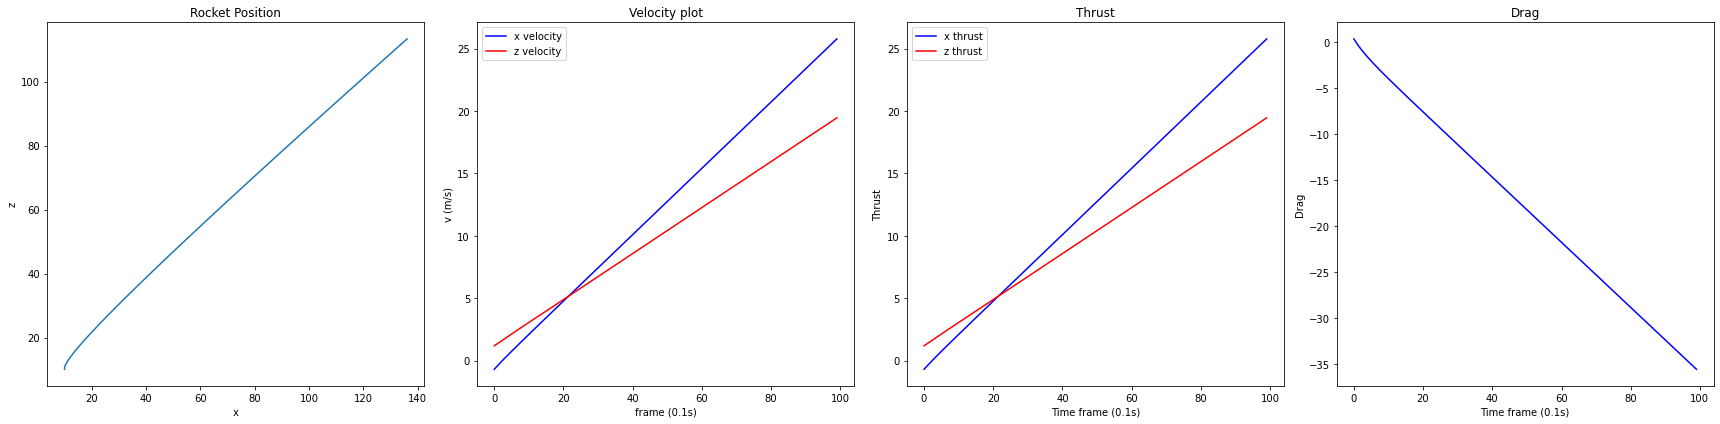

[22] loss: 45060.348
[23] loss: 34410.531
[24] loss: 26823.986
[25] loss: 21111.221
[26] loss: 16676.713
[27] loss: 13121.184
[28] loss: 10055.413
[29] loss: 6388.243
[30] loss: 3422.041
[31] loss: 2456.523


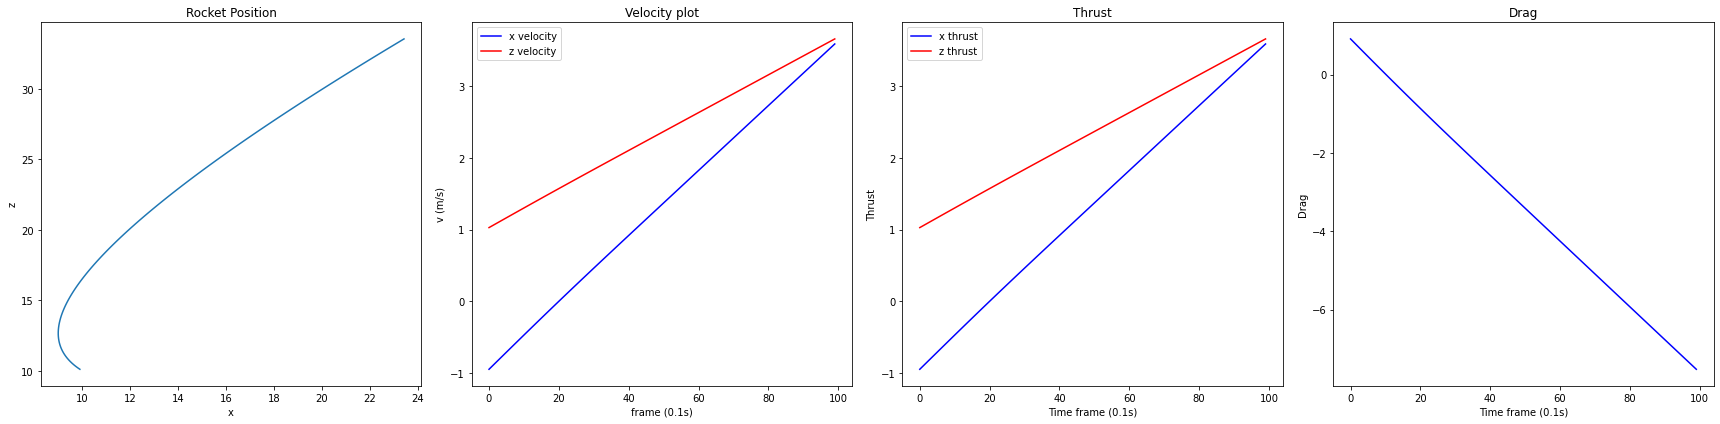

[32] loss: 1824.841
[33] loss: 1210.057
[34] loss: 1010.584
[35] loss: 837.094
[36] loss: 659.433
[37] loss: 574.997
[38] loss: 516.546
[39] loss: 479.954
[40] loss: 459.299
[41] loss: 444.888


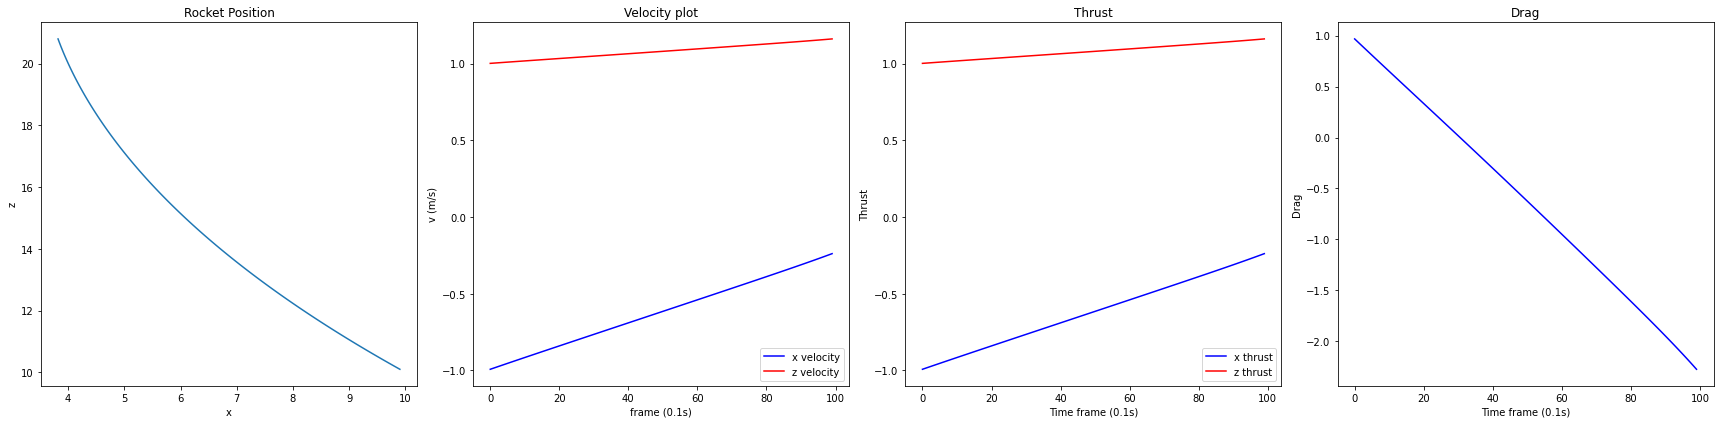

[42] loss: 433.081
[43] loss: 6877829.500
[44] loss: 6877829.500
[45] loss: 6877829.500
[46] loss: 6877829.500
[47] loss: 6877829.500
[48] loss: 6877829.500
[49] loss: 6877829.500
[50] loss: 6877829.500
[51] loss: 6877829.500


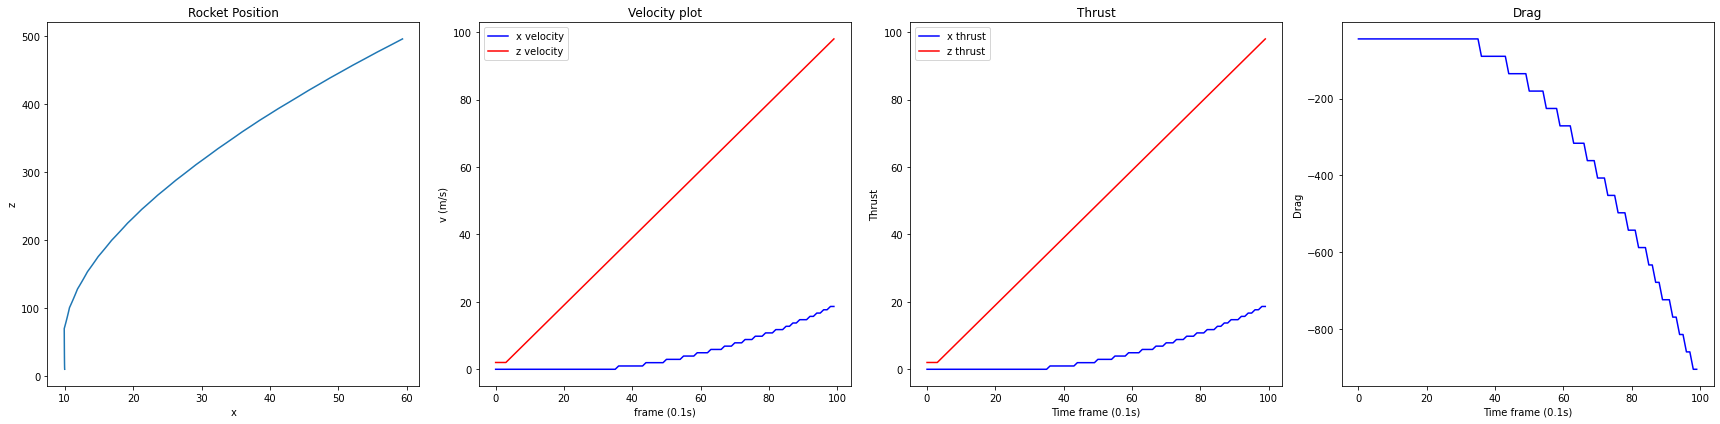

[52] loss: 6877829.500
[53] loss: 6877829.500
[54] loss: 6877829.500
[55] loss: 6877829.500
[56] loss: 6877829.500
[57] loss: 6877829.500
[58] loss: 6877829.500
[59] loss: 6877829.500
[60] loss: 6877829.500
[61] loss: 6877829.500


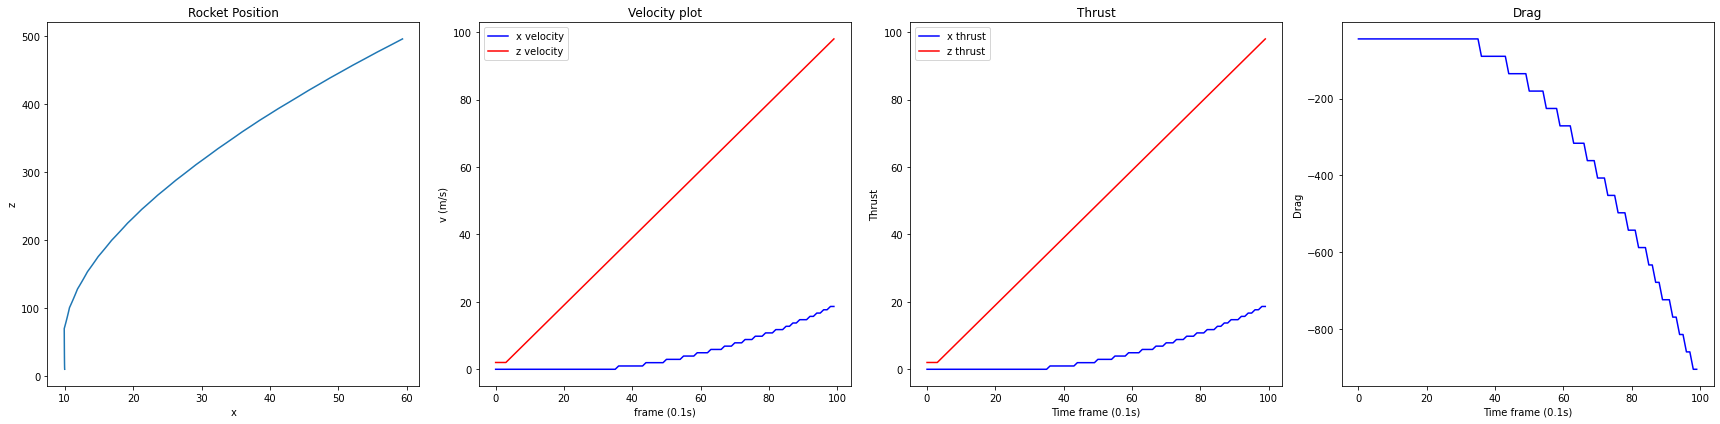

[62] loss: 6877829.500
[63] loss: 6877829.500
[64] loss: 6877829.500
[65] loss: 6877829.500
[66] loss: 6877829.500
[67] loss: 6877829.500
[68] loss: 6877829.500
[69] loss: 6877829.500
[70] loss: 6877829.500
[71] loss: 6877829.500


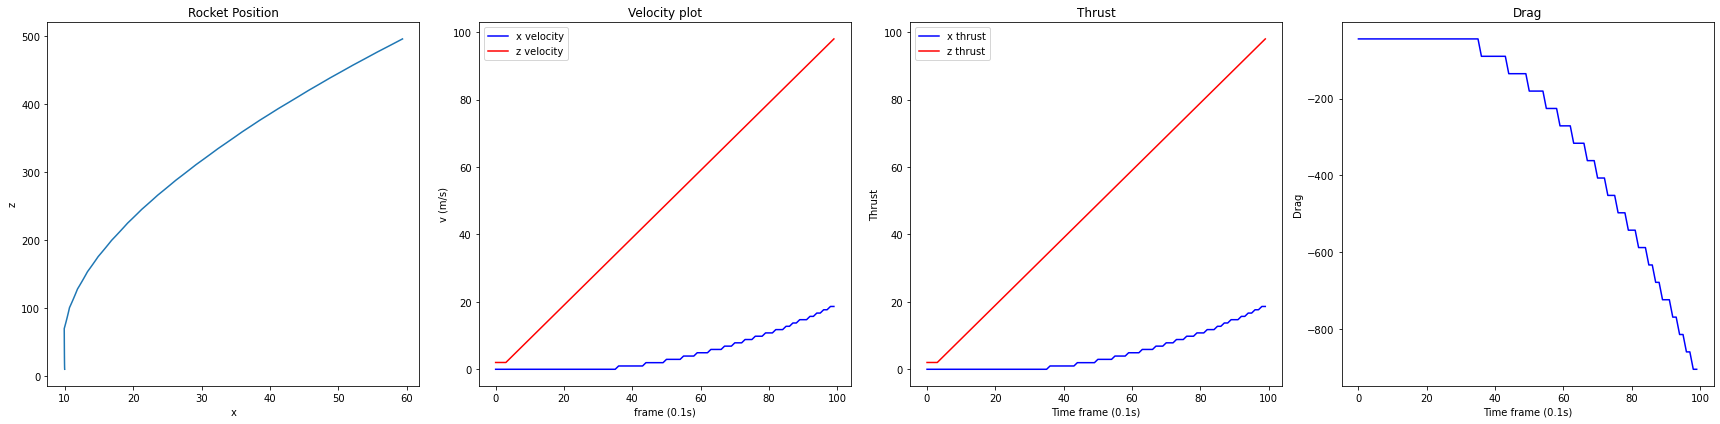

[72] loss: 6877829.500
[73] loss: 6877829.500
[74] loss: 6877829.500
[75] loss: 6877829.500
[76] loss: 6877829.500
[77] loss: 6877829.500
[78] loss: 6877829.500
[79] loss: 6877829.500
[80] loss: 6877829.500
[81] loss: 6877829.500


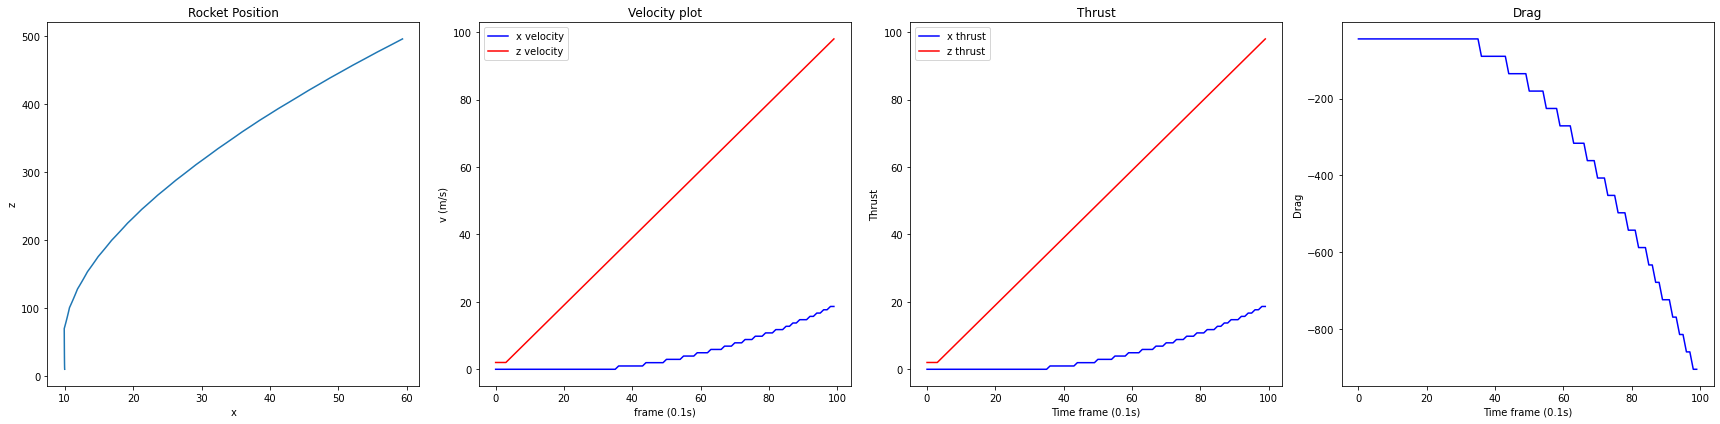

[82] loss: 6877829.500
[83] loss: 6877829.500
[84] loss: 6877829.500
[85] loss: 6877829.500
[86] loss: 6877829.500
[87] loss: 6877829.500
[88] loss: 6877829.500
[89] loss: 6877829.500
[90] loss: 6877829.500
[91] loss: 6877829.500


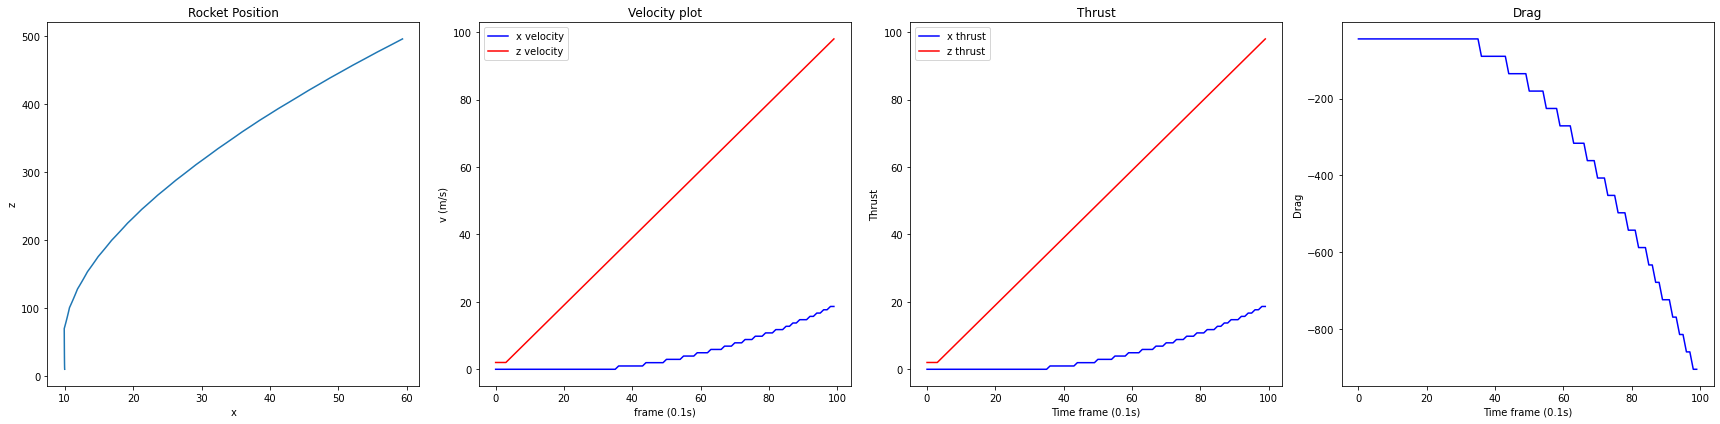

[92] loss: 6877829.500
[93] loss: 6877829.500
[94] loss: 6877829.500
[95] loss: 6877829.500
[96] loss: 6877829.500
[97] loss: 6877829.500
[98] loss: 6877829.500
[99] loss: 6877829.500
[100] loss: 6877829.500


In [249]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 6  # state space dimensions
dim_hidden = 10  # latent dimensions
dim_output = 3  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(100)  # solve the optimization problem